Instructions for build are here: https://github.com/eho-tacc/episimlab/issues/26

In [1]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)
import pandas as pd
import numpy as np
import xarray as xr
from xarray.ufuncs import isnan
import xsimlab as xs
from episimlab.partition import partition
from episimlab.setup.coords import InitDefaultCoords
import multiprocessing as mp
from datetime import datetime
from scripts.DemoATX import main
import matplotlib.pyplot as plt


# Run `episimlab` with Austin-Round Rock MSA parameters

There are two levels at which parameters are exposed to the user:

- configuration YAML file specifies all SEIR model parameters **except** beta (transmission probability)
- command line args to the model runner are used to specify initial model state and simulation duration

In [2]:
cli_pars = {
    'n_cores': 2,
    'config_fp': '/Users/kpierce/episimlab/scripts/DemoATX.yaml',
    'travel_fp': '/Users/kpierce/episimlab/data/full_first_wave_2020_travel.csv',
    'contacts_fp': '/Users/kpierce/episimlab/data/polymod_contacts.csv',
    'census_counts_csv': '/Users/kpierce/episimlab/data/data_lccf/census_pop1_rows1.csv',
    'beta': 0.035,
    'initial_ia': 10,
    'start_date': '3/11/2020',
    'end_date': '9/21/2020',
    'initial_vertex': 78712
}

DEBUG:root:'load_travel_df' took 5.47 seconds
DEBUG:root:step_start: 2020-03-11T00:00:00.000000000
DEBUG:root:step_end: 2020-03-11T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 22:42:27.420399


The date in Partition.get_travel_df is ['2020-03-11T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 22:42:36.519343
DEBUG:root:Starting pandas merge 1 at 2021-07-20 22:42:36.520109
DEBUG:root:Starting pandas merge 2 at 2021-07-20 22:42:46.928782
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 22:42:55.647664
DEBUG:root:'dask_partition' took 31.73 seconds
DEBUG:root:Building contact xarray at 2021-07-20 22:42:59.417359
DEBUG:root:step_start: NaT
DEBUG:root:step_end: 2020-03-11T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 22:43:00.250953


The date in Partition.get_travel_df is ['2020-03-11T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 22:43:09.093847
DEBUG:root:Starting pandas merge 1 at 2021-07-20 22:43:09.094568
DEBUG:root:Starting pandas merge 2 at 2021-07-20 22:43:17.548987
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 22:43:26.074557
DEBUG:root:'dask_partition' took 28.95 seconds
DEBUG:root:Building contact xarray at 2021-07-20 22:43:29.520195
DEBUG:root:step_start: 2020-03-11T00:00:00.000000000
DEBUG:root:step_end: 2020-03-12T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 22:43:29.753471


The date in Partition.get_travel_df is ['2020-03-11T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 22:43:38.540336
DEBUG:root:Starting pandas merge 1 at 2021-07-20 22:43:38.541025
DEBUG:root:Starting pandas merge 2 at 2021-07-20 22:43:46.520453
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 22:43:54.817593
DEBUG:root:'dask_partition' took 28.08 seconds
DEBUG:root:Building contact xarray at 2021-07-20 22:43:58.120965
DEBUG:root:step_start: 2020-03-12T00:00:00.000000000
DEBUG:root:step_end: 2020-03-13T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 22:43:58.342352


The date in Partition.get_travel_df is ['2020-03-12T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 22:44:07.755749
DEBUG:root:Starting pandas merge 1 at 2021-07-20 22:44:07.756494
DEBUG:root:Starting pandas merge 2 at 2021-07-20 22:44:16.439104
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 22:44:24.824537
DEBUG:root:'dask_partition' took 29.61 seconds
DEBUG:root:Building contact xarray at 2021-07-20 22:44:28.274108
DEBUG:root:step_start: 2020-03-13T00:00:00.000000000
DEBUG:root:step_end: 2020-03-14T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 22:44:28.495822


The date in Partition.get_travel_df is ['2020-03-13T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 22:44:37.534400
DEBUG:root:Starting pandas merge 1 at 2021-07-20 22:44:37.535155
DEBUG:root:Starting pandas merge 2 at 2021-07-20 22:44:46.393155
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 22:44:54.976953
DEBUG:root:'dask_partition' took 29.53 seconds
DEBUG:root:Building contact xarray at 2021-07-20 22:44:58.323966
DEBUG:root:step_start: 2020-03-14T00:00:00.000000000
DEBUG:root:step_end: 2020-03-15T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 22:44:58.590124


The date in Partition.get_travel_df is ['2020-03-14T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 22:45:07.180111
DEBUG:root:Starting pandas merge 1 at 2021-07-20 22:45:07.180908
DEBUG:root:Starting pandas merge 2 at 2021-07-20 22:45:15.067142
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 22:45:23.275028
DEBUG:root:'dask_partition' took 27.72 seconds
DEBUG:root:Building contact xarray at 2021-07-20 22:45:26.566046
DEBUG:root:step_start: 2020-03-15T00:00:00.000000000
DEBUG:root:step_end: 2020-03-16T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 22:45:26.782274


The date in Partition.get_travel_df is ['2020-03-15T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 22:45:35.996772
DEBUG:root:Starting pandas merge 1 at 2021-07-20 22:45:35.997460
DEBUG:root:Starting pandas merge 2 at 2021-07-20 22:45:43.927394
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 22:45:52.192460
DEBUG:root:'dask_partition' took 28.47 seconds
DEBUG:root:Building contact xarray at 2021-07-20 22:45:55.521838
DEBUG:root:step_start: 2020-03-16T00:00:00.000000000
DEBUG:root:step_end: 2020-03-17T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 22:45:55.739421


The date in Partition.get_travel_df is ['2020-03-16T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 22:46:04.276475
DEBUG:root:Starting pandas merge 1 at 2021-07-20 22:46:04.277441
DEBUG:root:Starting pandas merge 2 at 2021-07-20 22:46:12.240261
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 22:46:20.475472
DEBUG:root:'dask_partition' took 27.78 seconds
DEBUG:root:Building contact xarray at 2021-07-20 22:46:23.814345
DEBUG:root:step_start: 2020-03-17T00:00:00.000000000
DEBUG:root:step_end: 2020-03-18T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 22:46:24.049891


The date in Partition.get_travel_df is ['2020-03-17T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 22:46:32.907449
DEBUG:root:Starting pandas merge 1 at 2021-07-20 22:46:32.908181
DEBUG:root:Starting pandas merge 2 at 2021-07-20 22:46:41.047310
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 22:46:49.409018
DEBUG:root:'dask_partition' took 28.44 seconds
DEBUG:root:Building contact xarray at 2021-07-20 22:46:52.790222
DEBUG:root:step_start: 2020-03-18T00:00:00.000000000
DEBUG:root:step_end: 2020-03-19T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 22:46:53.003493


The date in Partition.get_travel_df is ['2020-03-18T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 22:47:01.326698
DEBUG:root:Starting pandas merge 1 at 2021-07-20 22:47:01.327420
DEBUG:root:Starting pandas merge 2 at 2021-07-20 22:47:09.470294
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 22:47:17.833741
DEBUG:root:'dask_partition' took 27.86 seconds
DEBUG:root:Building contact xarray at 2021-07-20 22:47:21.154771
DEBUG:root:step_start: 2020-03-19T00:00:00.000000000
DEBUG:root:step_end: 2020-03-20T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 22:47:21.373242


The date in Partition.get_travel_df is ['2020-03-19T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 22:47:29.796018
DEBUG:root:Starting pandas merge 1 at 2021-07-20 22:47:29.796746
DEBUG:root:Starting pandas merge 2 at 2021-07-20 22:47:37.865591
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 22:47:46.199882
DEBUG:root:'dask_partition' took 27.84 seconds
DEBUG:root:Building contact xarray at 2021-07-20 22:47:49.493933
DEBUG:root:step_start: 2020-03-20T00:00:00.000000000
DEBUG:root:step_end: 2020-03-21T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 22:47:49.709078


The date in Partition.get_travel_df is ['2020-03-20T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 22:47:58.149231
DEBUG:root:Starting pandas merge 1 at 2021-07-20 22:47:58.149938
DEBUG:root:Starting pandas merge 2 at 2021-07-20 22:48:06.209458
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 22:48:14.585641
DEBUG:root:'dask_partition' took 27.93 seconds
DEBUG:root:Building contact xarray at 2021-07-20 22:48:17.926677
DEBUG:root:step_start: 2020-03-21T00:00:00.000000000
DEBUG:root:step_end: 2020-03-22T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 22:48:18.145542


The date in Partition.get_travel_df is ['2020-03-21T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 22:48:27.032884
DEBUG:root:Starting pandas merge 1 at 2021-07-20 22:48:27.033635
DEBUG:root:Starting pandas merge 2 at 2021-07-20 22:48:35.027568
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 22:48:43.136536
DEBUG:root:'dask_partition' took 27.97 seconds
DEBUG:root:Building contact xarray at 2021-07-20 22:48:46.385637
DEBUG:root:step_start: 2020-03-22T00:00:00.000000000
DEBUG:root:step_end: 2020-03-23T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 22:48:46.599114


The date in Partition.get_travel_df is ['2020-03-22T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 22:48:55.263558
DEBUG:root:Starting pandas merge 1 at 2021-07-20 22:48:55.264308
DEBUG:root:Starting pandas merge 2 at 2021-07-20 22:49:03.136819
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 22:49:11.309693
DEBUG:root:'dask_partition' took 27.72 seconds
DEBUG:root:Building contact xarray at 2021-07-20 22:49:14.590137
DEBUG:root:step_start: 2020-03-23T00:00:00.000000000
DEBUG:root:step_end: 2020-03-24T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 22:49:14.809031


The date in Partition.get_travel_df is ['2020-03-23T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 22:49:23.545441
DEBUG:root:Starting pandas merge 1 at 2021-07-20 22:49:23.546141
DEBUG:root:Starting pandas merge 2 at 2021-07-20 22:49:31.726852
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 22:49:40.067795
DEBUG:root:'dask_partition' took 28.38 seconds
DEBUG:root:Building contact xarray at 2021-07-20 22:49:43.467123
DEBUG:root:step_start: 2020-03-24T00:00:00.000000000
DEBUG:root:step_end: 2020-03-25T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 22:49:43.701264


The date in Partition.get_travel_df is ['2020-03-24T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 22:49:52.365362
DEBUG:root:Starting pandas merge 1 at 2021-07-20 22:49:52.366062
DEBUG:root:Starting pandas merge 2 at 2021-07-20 22:50:00.253445
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 22:50:08.466844
DEBUG:root:'dask_partition' took 27.76 seconds
DEBUG:root:Building contact xarray at 2021-07-20 22:50:11.764004
DEBUG:root:step_start: 2020-03-25T00:00:00.000000000
DEBUG:root:step_end: 2020-03-26T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 22:50:11.980133


The date in Partition.get_travel_df is ['2020-03-25T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 22:50:20.742900
DEBUG:root:Starting pandas merge 1 at 2021-07-20 22:50:20.743819
DEBUG:root:Starting pandas merge 2 at 2021-07-20 22:50:28.518382
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 22:50:36.745952
DEBUG:root:'dask_partition' took 27.78 seconds
DEBUG:root:Building contact xarray at 2021-07-20 22:50:40.021419
DEBUG:root:step_start: 2020-03-26T00:00:00.000000000
DEBUG:root:step_end: 2020-03-27T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 22:50:40.241324


The date in Partition.get_travel_df is ['2020-03-26T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 22:50:48.813316
DEBUG:root:Starting pandas merge 1 at 2021-07-20 22:50:48.814092
DEBUG:root:Starting pandas merge 2 at 2021-07-20 22:50:56.689398
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 22:51:04.923510
DEBUG:root:'dask_partition' took 27.66 seconds
DEBUG:root:Building contact xarray at 2021-07-20 22:51:08.193956
DEBUG:root:step_start: 2020-03-27T00:00:00.000000000
DEBUG:root:step_end: 2020-03-28T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 22:51:08.407200


The date in Partition.get_travel_df is ['2020-03-27T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 22:51:17.049854
DEBUG:root:Starting pandas merge 1 at 2021-07-20 22:51:17.050661
DEBUG:root:Starting pandas merge 2 at 2021-07-20 22:51:24.989119
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 22:51:33.149640
DEBUG:root:'dask_partition' took 27.76 seconds
DEBUG:root:Building contact xarray at 2021-07-20 22:51:36.435144
DEBUG:root:step_start: 2020-03-28T00:00:00.000000000
DEBUG:root:step_end: 2020-03-29T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 22:51:36.650887


The date in Partition.get_travel_df is ['2020-03-28T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 22:51:45.503661
DEBUG:root:Starting pandas merge 1 at 2021-07-20 22:51:45.504382
DEBUG:root:Starting pandas merge 2 at 2021-07-20 22:51:53.303021
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 22:52:01.481217
DEBUG:root:'dask_partition' took 27.87 seconds
DEBUG:root:Building contact xarray at 2021-07-20 22:52:04.809140
DEBUG:root:step_start: 2020-03-29T00:00:00.000000000
DEBUG:root:step_end: 2020-03-30T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 22:52:05.029972


The date in Partition.get_travel_df is ['2020-03-29T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 22:52:13.772698
DEBUG:root:Starting pandas merge 1 at 2021-07-20 22:52:13.773474
DEBUG:root:Starting pandas merge 2 at 2021-07-20 22:52:21.597282
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 22:52:29.783700
DEBUG:root:'dask_partition' took 27.91 seconds
DEBUG:root:Building contact xarray at 2021-07-20 22:52:33.201873
DEBUG:root:step_start: 2020-03-30T00:00:00.000000000
DEBUG:root:step_end: 2020-03-31T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 22:52:33.414155


The date in Partition.get_travel_df is ['2020-03-30T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 22:52:42.028851
DEBUG:root:Starting pandas merge 1 at 2021-07-20 22:52:42.029660
DEBUG:root:Starting pandas merge 2 at 2021-07-20 22:52:49.998022
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 22:52:58.343171
DEBUG:root:'dask_partition' took 27.98 seconds
DEBUG:root:Building contact xarray at 2021-07-20 22:53:01.687151
DEBUG:root:step_start: 2020-03-31T00:00:00.000000000
DEBUG:root:step_end: 2020-04-01T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 22:53:01.902421


The date in Partition.get_travel_df is ['2020-03-31T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 22:53:10.496054
DEBUG:root:Starting pandas merge 1 at 2021-07-20 22:53:10.496761
DEBUG:root:Starting pandas merge 2 at 2021-07-20 22:53:18.532225
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 22:53:26.968071
DEBUG:root:'dask_partition' took 28.20 seconds
DEBUG:root:Building contact xarray at 2021-07-20 22:53:30.390399
DEBUG:root:step_start: 2020-04-01T00:00:00.000000000
DEBUG:root:step_end: 2020-04-02T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 22:53:30.626528


The date in Partition.get_travel_df is ['2020-04-01T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 22:53:39.443347
DEBUG:root:Starting pandas merge 1 at 2021-07-20 22:53:39.444102
DEBUG:root:Starting pandas merge 2 at 2021-07-20 22:53:47.366428
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 22:53:55.444281
DEBUG:root:'dask_partition' took 28.05 seconds
DEBUG:root:Building contact xarray at 2021-07-20 22:53:58.970665
DEBUG:root:step_start: 2020-04-02T00:00:00.000000000
DEBUG:root:step_end: 2020-04-03T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 22:53:59.185201


The date in Partition.get_travel_df is ['2020-04-02T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 22:54:08.064196
DEBUG:root:Starting pandas merge 1 at 2021-07-20 22:54:08.064968
DEBUG:root:Starting pandas merge 2 at 2021-07-20 22:54:15.975079
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 22:54:24.279118
DEBUG:root:'dask_partition' took 28.58 seconds
DEBUG:root:Building contact xarray at 2021-07-20 22:54:28.086668
DEBUG:root:step_start: 2020-04-03T00:00:00.000000000
DEBUG:root:step_end: 2020-04-04T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 22:54:28.322105


The date in Partition.get_travel_df is ['2020-04-03T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 22:54:38.035860
DEBUG:root:Starting pandas merge 1 at 2021-07-20 22:54:38.036677
DEBUG:root:Starting pandas merge 2 at 2021-07-20 22:54:46.338600
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 22:54:54.782351
DEBUG:root:'dask_partition' took 29.57 seconds
DEBUG:root:Building contact xarray at 2021-07-20 22:54:58.188827
DEBUG:root:step_start: 2020-04-04T00:00:00.000000000
DEBUG:root:step_end: 2020-04-05T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 22:54:58.411953


The date in Partition.get_travel_df is ['2020-04-04T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 22:55:06.927545
DEBUG:root:Starting pandas merge 1 at 2021-07-20 22:55:06.928316
DEBUG:root:Starting pandas merge 2 at 2021-07-20 22:55:14.875471
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 22:55:23.071079
DEBUG:root:'dask_partition' took 27.70 seconds
DEBUG:root:Building contact xarray at 2021-07-20 22:55:26.383913
DEBUG:root:step_start: 2020-04-05T00:00:00.000000000
DEBUG:root:step_end: 2020-04-06T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 22:55:26.596006


The date in Partition.get_travel_df is ['2020-04-05T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 22:55:35.457411
DEBUG:root:Starting pandas merge 1 at 2021-07-20 22:55:35.458226
DEBUG:root:Starting pandas merge 2 at 2021-07-20 22:55:43.306342
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 22:55:51.369043
DEBUG:root:'dask_partition' took 27.78 seconds
DEBUG:root:Building contact xarray at 2021-07-20 22:55:54.651117
DEBUG:root:step_start: 2020-04-06T00:00:00.000000000
DEBUG:root:step_end: 2020-04-07T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 22:55:54.869167


The date in Partition.get_travel_df is ['2020-04-06T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 22:56:03.783364
DEBUG:root:Starting pandas merge 1 at 2021-07-20 22:56:03.784126
DEBUG:root:Starting pandas merge 2 at 2021-07-20 22:56:11.714556
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 22:56:19.768536
DEBUG:root:'dask_partition' took 27.94 seconds
DEBUG:root:Building contact xarray at 2021-07-20 22:56:23.091043
DEBUG:root:step_start: 2020-04-07T00:00:00.000000000
DEBUG:root:step_end: 2020-04-08T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 22:56:23.306451


The date in Partition.get_travel_df is ['2020-04-07T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 22:56:32.154234
DEBUG:root:Starting pandas merge 1 at 2021-07-20 22:56:32.155018
DEBUG:root:Starting pandas merge 2 at 2021-07-20 22:56:39.987556
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 22:56:47.872080
DEBUG:root:'dask_partition' took 27.57 seconds
DEBUG:root:Building contact xarray at 2021-07-20 22:56:51.150768
DEBUG:root:step_start: 2020-04-08T00:00:00.000000000
DEBUG:root:step_end: 2020-04-09T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 22:56:51.361617


The date in Partition.get_travel_df is ['2020-04-08T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 22:57:00.482197
DEBUG:root:Starting pandas merge 1 at 2021-07-20 22:57:00.483065
DEBUG:root:Starting pandas merge 2 at 2021-07-20 22:57:09.143830
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 22:57:17.424213
DEBUG:root:'dask_partition' took 29.31 seconds
DEBUG:root:Building contact xarray at 2021-07-20 22:57:20.954986
DEBUG:root:step_start: 2020-04-09T00:00:00.000000000
DEBUG:root:step_end: 2020-04-10T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 22:57:21.181904


The date in Partition.get_travel_df is ['2020-04-09T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 22:57:29.793236
DEBUG:root:Starting pandas merge 1 at 2021-07-20 22:57:29.794076
DEBUG:root:Starting pandas merge 2 at 2021-07-20 22:57:37.818012
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 22:57:46.017115
DEBUG:root:'dask_partition' took 27.85 seconds
DEBUG:root:Building contact xarray at 2021-07-20 22:57:49.298895
DEBUG:root:step_start: 2020-04-10T00:00:00.000000000
DEBUG:root:step_end: 2020-04-11T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 22:57:49.521879


The date in Partition.get_travel_df is ['2020-04-10T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 22:57:58.253047
DEBUG:root:Starting pandas merge 1 at 2021-07-20 22:57:58.254137
DEBUG:root:Starting pandas merge 2 at 2021-07-20 22:58:06.103168
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 22:58:14.201581
DEBUG:root:'dask_partition' took 27.72 seconds
DEBUG:root:Building contact xarray at 2021-07-20 22:58:17.502050
DEBUG:root:step_start: 2020-04-11T00:00:00.000000000
DEBUG:root:step_end: 2020-04-12T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 22:58:17.727619


The date in Partition.get_travel_df is ['2020-04-11T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 22:58:26.578344
DEBUG:root:Starting pandas merge 1 at 2021-07-20 22:58:26.579216
DEBUG:root:Starting pandas merge 2 at 2021-07-20 22:58:34.581527
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 22:58:42.625153
DEBUG:root:'dask_partition' took 27.79 seconds
DEBUG:root:Building contact xarray at 2021-07-20 22:58:45.807925
DEBUG:root:step_start: 2020-04-12T00:00:00.000000000
DEBUG:root:step_end: 2020-04-13T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 22:58:46.030630


The date in Partition.get_travel_df is ['2020-04-12T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 22:58:54.682685
DEBUG:root:Starting pandas merge 1 at 2021-07-20 22:58:54.683397
DEBUG:root:Starting pandas merge 2 at 2021-07-20 22:59:03.303197
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 22:59:11.725281
DEBUG:root:'dask_partition' took 28.70 seconds
DEBUG:root:Building contact xarray at 2021-07-20 22:59:15.027876
DEBUG:root:step_start: 2020-04-13T00:00:00.000000000
DEBUG:root:step_end: 2020-04-14T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 22:59:15.252178


The date in Partition.get_travel_df is ['2020-04-13T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 22:59:23.672197
DEBUG:root:Starting pandas merge 1 at 2021-07-20 22:59:23.672920
DEBUG:root:Starting pandas merge 2 at 2021-07-20 22:59:31.675855
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 22:59:39.995848
DEBUG:root:'dask_partition' took 27.80 seconds
DEBUG:root:Building contact xarray at 2021-07-20 22:59:43.345380
DEBUG:root:step_start: 2020-04-14T00:00:00.000000000
DEBUG:root:step_end: 2020-04-15T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 22:59:43.569173


The date in Partition.get_travel_df is ['2020-04-14T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 22:59:52.168211
DEBUG:root:Starting pandas merge 1 at 2021-07-20 22:59:52.168951
DEBUG:root:Starting pandas merge 2 at 2021-07-20 22:59:59.898305
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:00:08.108152
DEBUG:root:'dask_partition' took 27.56 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:00:11.389377
DEBUG:root:step_start: 2020-04-15T00:00:00.000000000
DEBUG:root:step_end: 2020-04-16T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:00:11.609832


The date in Partition.get_travel_df is ['2020-04-15T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:00:20.307648
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:00:20.308390
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:00:28.155584
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:00:36.364654
DEBUG:root:'dask_partition' took 27.79 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:00:39.672487
DEBUG:root:step_start: 2020-04-16T00:00:00.000000000
DEBUG:root:step_end: 2020-04-17T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:00:39.885859


The date in Partition.get_travel_df is ['2020-04-16T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:00:48.464644
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:00:48.465373
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:00:56.261142
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:01:04.378649
DEBUG:root:'dask_partition' took 27.51 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:01:07.668546
DEBUG:root:step_start: 2020-04-17T00:00:00.000000000
DEBUG:root:step_end: 2020-04-18T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:01:07.887420


The date in Partition.get_travel_df is ['2020-04-17T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:01:16.363403
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:01:16.364198
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:01:24.147218
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:01:32.396284
DEBUG:root:'dask_partition' took 27.51 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:01:35.660035
DEBUG:root:step_start: 2020-04-18T00:00:00.000000000
DEBUG:root:step_end: 2020-04-19T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:01:35.869841


The date in Partition.get_travel_df is ['2020-04-18T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:01:44.538980
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:01:44.539718
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:01:52.474356
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:02:00.520375
DEBUG:root:'dask_partition' took 27.68 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:02:03.811596
DEBUG:root:step_start: 2020-04-19T00:00:00.000000000
DEBUG:root:step_end: 2020-04-20T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:02:04.029395


The date in Partition.get_travel_df is ['2020-04-19T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:02:12.583199
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:02:12.583933
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:02:20.312466
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:02:28.461713
DEBUG:root:'dask_partition' took 27.50 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:02:31.788277
DEBUG:root:step_start: 2020-04-20T00:00:00.000000000
DEBUG:root:step_end: 2020-04-21T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:02:32.008971


The date in Partition.get_travel_df is ['2020-04-20T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:02:40.599153
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:02:40.599875
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:02:48.697076
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:02:57.057158
DEBUG:root:'dask_partition' took 28.08 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:03:00.378635
DEBUG:root:step_start: 2020-04-21T00:00:00.000000000
DEBUG:root:step_end: 2020-04-22T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:03:00.598217


The date in Partition.get_travel_df is ['2020-04-21T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:03:09.431213
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:03:09.431951
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:03:17.385123
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:03:25.549095
DEBUG:root:'dask_partition' took 27.97 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:03:28.846111
DEBUG:root:step_start: 2020-04-22T00:00:00.000000000
DEBUG:root:step_end: 2020-04-23T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:03:29.064325


The date in Partition.get_travel_df is ['2020-04-22T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:03:38.105046
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:03:38.105954
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:03:47.177648
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:03:55.574844
DEBUG:root:'dask_partition' took 29.53 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:03:58.880696
DEBUG:root:step_start: 2020-04-23T00:00:00.000000000
DEBUG:root:step_end: 2020-04-24T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:03:59.280555


The date in Partition.get_travel_df is ['2020-04-23T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:04:07.938681
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:04:07.939418
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:04:15.729118
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:04:23.903783
DEBUG:root:'dask_partition' took 27.66 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:04:27.220968
DEBUG:root:step_start: 2020-04-24T00:00:00.000000000
DEBUG:root:step_end: 2020-04-25T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:04:27.434505


The date in Partition.get_travel_df is ['2020-04-24T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:04:36.117000
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:04:36.117795
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:04:43.971791
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:04:52.318623
DEBUG:root:'dask_partition' took 27.89 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:04:55.592202
DEBUG:root:step_start: 2020-04-25T00:00:00.000000000
DEBUG:root:step_end: 2020-04-26T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:04:55.803249


The date in Partition.get_travel_df is ['2020-04-25T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:05:04.697097
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:05:04.697839
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:05:13.914460
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:05:22.332945
DEBUG:root:'dask_partition' took 29.58 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:05:25.684410
DEBUG:root:step_start: 2020-04-26T00:00:00.000000000
DEBUG:root:step_end: 2020-04-27T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:05:25.912245


The date in Partition.get_travel_df is ['2020-04-26T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:05:34.935684
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:05:34.936452
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:05:42.941250
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:05:51.128514
DEBUG:root:'dask_partition' took 28.26 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:05:54.458852
DEBUG:root:step_start: 2020-04-27T00:00:00.000000000
DEBUG:root:step_end: 2020-04-28T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:05:54.684073


The date in Partition.get_travel_df is ['2020-04-27T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:06:03.453592
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:06:03.454327
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:06:11.416776
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:06:19.583933
DEBUG:root:'dask_partition' took 27.92 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:06:22.902172
DEBUG:root:step_start: 2020-04-28T00:00:00.000000000
DEBUG:root:step_end: 2020-04-29T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:06:23.121378


The date in Partition.get_travel_df is ['2020-04-28T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:06:31.744933
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:06:31.745669
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:06:39.737403
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:06:48.006731
DEBUG:root:'dask_partition' took 27.89 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:06:51.305753
DEBUG:root:step_start: 2020-04-29T00:00:00.000000000
DEBUG:root:step_end: 2020-04-30T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:06:51.542003


The date in Partition.get_travel_df is ['2020-04-29T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:07:00.178267
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:07:00.179521
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:07:07.979358
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:07:16.060660
DEBUG:root:'dask_partition' took 27.49 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:07:19.289482
DEBUG:root:step_start: 2020-04-30T00:00:00.000000000
DEBUG:root:step_end: 2020-05-01T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:07:19.500580


The date in Partition.get_travel_df is ['2020-04-30T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:07:28.149776
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:07:28.150508
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:07:36.243666
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:07:44.656240
DEBUG:root:'dask_partition' took 28.17 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:07:47.956111
DEBUG:root:step_start: 2020-05-01T00:00:00.000000000
DEBUG:root:step_end: 2020-05-02T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:07:48.175644


The date in Partition.get_travel_df is ['2020-05-01T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:07:56.838329
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:07:56.839073
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:08:04.874533
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:08:13.176927
DEBUG:root:'dask_partition' took 28.06 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:08:16.511249
DEBUG:root:step_start: 2020-05-02T00:00:00.000000000
DEBUG:root:step_end: 2020-05-03T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:08:16.734208


The date in Partition.get_travel_df is ['2020-05-02T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:08:25.290291
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:08:25.290970
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:08:33.726748
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:08:42.130914
DEBUG:root:'dask_partition' took 28.45 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:08:45.473260
DEBUG:root:step_start: 2020-05-03T00:00:00.000000000
DEBUG:root:step_end: 2020-05-04T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:08:45.693539


The date in Partition.get_travel_df is ['2020-05-03T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:08:54.102114
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:08:54.102849
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:09:02.102382
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:09:10.544049
DEBUG:root:'dask_partition' took 27.86 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:09:13.835663
DEBUG:root:step_start: 2020-05-04T00:00:00.000000000
DEBUG:root:step_end: 2020-05-05T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:09:14.050134


The date in Partition.get_travel_df is ['2020-05-04T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:09:22.707934
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:09:22.708661
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:09:30.651549
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:09:39.145065
DEBUG:root:'dask_partition' took 28.08 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:09:42.413138
DEBUG:root:step_start: 2020-05-05T00:00:00.000000000
DEBUG:root:step_end: 2020-05-06T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:09:42.629100


The date in Partition.get_travel_df is ['2020-05-05T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:09:51.760640
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:09:51.761393
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:09:59.580469
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:10:07.473967
DEBUG:root:'dask_partition' took 27.76 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:10:10.665688
DEBUG:root:step_start: 2020-05-06T00:00:00.000000000
DEBUG:root:step_end: 2020-05-07T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:10:10.863404


The date in Partition.get_travel_df is ['2020-05-06T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:10:19.242820
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:10:19.243566
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:10:27.624591
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:10:35.562466
DEBUG:root:'dask_partition' took 27.61 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:10:38.737549
DEBUG:root:step_start: 2020-05-07T00:00:00.000000000
DEBUG:root:step_end: 2020-05-08T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:10:38.950192


The date in Partition.get_travel_df is ['2020-05-07T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:10:47.035272
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:10:47.035994
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:10:54.474018
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:11:02.184213
DEBUG:root:'dask_partition' took 26.09 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:11:05.308152
DEBUG:root:step_start: 2020-05-08T00:00:00.000000000
DEBUG:root:step_end: 2020-05-09T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:11:05.503627


The date in Partition.get_travel_df is ['2020-05-08T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:11:14.097602
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:11:14.098329
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:11:21.490690
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:11:29.039808
DEBUG:root:'dask_partition' took 26.52 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:11:32.280381
DEBUG:root:step_start: 2020-05-09T00:00:00.000000000
DEBUG:root:step_end: 2020-05-10T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:11:32.501329


The date in Partition.get_travel_df is ['2020-05-09T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:11:40.810318
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:11:40.810988
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:11:48.301696
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:11:55.958570
DEBUG:root:'dask_partition' took 26.31 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:11:59.073118
DEBUG:root:step_start: 2020-05-10T00:00:00.000000000
DEBUG:root:step_end: 2020-05-11T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:11:59.266013


The date in Partition.get_travel_df is ['2020-05-10T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:12:07.303223
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:12:07.303904
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:12:14.719959
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:12:22.376478
DEBUG:root:'dask_partition' took 25.99 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:12:25.510475
DEBUG:root:step_start: 2020-05-11T00:00:00.000000000
DEBUG:root:step_end: 2020-05-12T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:12:25.696794


The date in Partition.get_travel_df is ['2020-05-11T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:12:33.941678
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:12:33.942466
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:12:41.664579
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:12:49.521914
DEBUG:root:'dask_partition' took 26.72 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:12:52.695244
DEBUG:root:step_start: 2020-05-12T00:00:00.000000000
DEBUG:root:step_end: 2020-05-13T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:12:52.883121


The date in Partition.get_travel_df is ['2020-05-12T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:13:01.147998
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:13:01.148893
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:13:08.230816
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:13:16.131995
DEBUG:root:'dask_partition' took 26.13 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:13:19.295562
DEBUG:root:step_start: 2020-05-13T00:00:00.000000000
DEBUG:root:step_end: 2020-05-14T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:13:19.529871


The date in Partition.get_travel_df is ['2020-05-13T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:13:27.714070
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:13:27.714794
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:13:35.279920
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:13:42.857980
DEBUG:root:'dask_partition' took 26.16 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:13:45.939490
DEBUG:root:step_start: 2020-05-14T00:00:00.000000000
DEBUG:root:step_end: 2020-05-15T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:13:46.127888


The date in Partition.get_travel_df is ['2020-05-14T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:13:54.237903
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:13:54.238728
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:14:01.585687
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:14:09.261229
DEBUG:root:'dask_partition' took 26.02 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:14:12.388077
DEBUG:root:step_start: 2020-05-15T00:00:00.000000000
DEBUG:root:step_end: 2020-05-16T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:14:12.577511


The date in Partition.get_travel_df is ['2020-05-15T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:14:21.019075
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:14:21.019906
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:14:28.414914
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:14:36.246877
DEBUG:root:'dask_partition' took 26.52 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:14:39.343096
DEBUG:root:step_start: 2020-05-16T00:00:00.000000000
DEBUG:root:step_end: 2020-05-17T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:14:39.534945


The date in Partition.get_travel_df is ['2020-05-16T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:14:47.861151
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:14:47.861866
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:14:55.502836
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:15:03.357015
DEBUG:root:'dask_partition' took 26.71 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:15:06.509394
DEBUG:root:step_start: 2020-05-17T00:00:00.000000000
DEBUG:root:step_end: 2020-05-18T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:15:06.708595


The date in Partition.get_travel_df is ['2020-05-17T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:15:14.745781
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:15:14.746548
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:15:22.370488
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:15:30.324914
DEBUG:root:'dask_partition' took 26.42 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:15:33.398404
DEBUG:root:step_start: 2020-05-18T00:00:00.000000000
DEBUG:root:step_end: 2020-05-19T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:15:33.598356


The date in Partition.get_travel_df is ['2020-05-18T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:15:42.021455
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:15:42.022202
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:15:50.154424
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:15:57.947773
DEBUG:root:'dask_partition' took 27.23 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:16:01.097957
DEBUG:root:step_start: 2020-05-19T00:00:00.000000000
DEBUG:root:step_end: 2020-05-20T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:16:01.301143


The date in Partition.get_travel_df is ['2020-05-19T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:16:09.549858
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:16:09.550588
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:16:16.932773
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:16:24.531768
DEBUG:root:'dask_partition' took 26.21 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:16:27.758961
DEBUG:root:step_start: 2020-05-20T00:00:00.000000000
DEBUG:root:step_end: 2020-05-21T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:16:27.946618


The date in Partition.get_travel_df is ['2020-05-20T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:16:36.409060
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:16:36.409843
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:16:43.824414
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:16:51.324215
DEBUG:root:'dask_partition' took 26.23 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:16:54.422970
DEBUG:root:step_start: 2020-05-21T00:00:00.000000000
DEBUG:root:step_end: 2020-05-22T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:16:54.626195


The date in Partition.get_travel_df is ['2020-05-21T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:17:02.680955
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:17:02.681729
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:17:10.018909
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:17:17.691485
DEBUG:root:'dask_partition' took 25.91 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:17:20.779402
DEBUG:root:step_start: 2020-05-22T00:00:00.000000000
DEBUG:root:step_end: 2020-05-23T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:17:20.968944


The date in Partition.get_travel_df is ['2020-05-22T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:17:29.042037
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:17:29.042760
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:17:36.598852
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:17:44.345973
DEBUG:root:'dask_partition' took 26.22 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:17:47.463283
DEBUG:root:step_start: 2020-05-23T00:00:00.000000000
DEBUG:root:step_end: 2020-05-24T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:17:47.648827


The date in Partition.get_travel_df is ['2020-05-23T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:17:56.170304
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:17:56.170974
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:18:03.842033
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:18:11.780074
DEBUG:root:'dask_partition' took 26.99 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:18:14.906662
DEBUG:root:step_start: 2020-05-24T00:00:00.000000000
DEBUG:root:step_end: 2020-05-25T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:18:15.107561


The date in Partition.get_travel_df is ['2020-05-24T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:18:23.144803
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:18:23.145603
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:18:32.657157
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:18:40.836332
DEBUG:root:'dask_partition' took 28.73 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:18:44.101159
DEBUG:root:step_start: 2020-05-25T00:00:00.000000000
DEBUG:root:step_end: 2020-05-26T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:18:44.293603


The date in Partition.get_travel_df is ['2020-05-25T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:18:52.677974
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:18:52.678781
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:19:00.150677
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:19:07.798662
DEBUG:root:'dask_partition' took 26.34 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:19:10.879531
DEBUG:root:step_start: 2020-05-26T00:00:00.000000000
DEBUG:root:step_end: 2020-05-27T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:19:11.066588


The date in Partition.get_travel_df is ['2020-05-26T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:19:19.160946
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:19:19.164225
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:19:26.543359
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:19:34.236400
DEBUG:root:'dask_partition' took 26.07 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:19:37.377686
DEBUG:root:step_start: 2020-05-27T00:00:00.000000000
DEBUG:root:step_end: 2020-05-28T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:19:37.565046


The date in Partition.get_travel_df is ['2020-05-27T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:19:46.005463
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:19:46.006208
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:19:53.452737
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:20:01.203276
DEBUG:root:'dask_partition' took 26.55 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:20:04.381618
DEBUG:root:step_start: 2020-05-28T00:00:00.000000000
DEBUG:root:step_end: 2020-05-29T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:20:04.590076


The date in Partition.get_travel_df is ['2020-05-28T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:20:12.530598
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:20:12.531371
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:20:20.434683
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:20:28.476197
DEBUG:root:'dask_partition' took 26.85 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:20:31.714428
DEBUG:root:step_start: 2020-05-29T00:00:00.000000000
DEBUG:root:step_end: 2020-05-30T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:20:31.906892


The date in Partition.get_travel_df is ['2020-05-29T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:20:40.425924
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:20:40.427213
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:20:48.141820
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:20:56.041429
DEBUG:root:'dask_partition' took 27.03 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:20:59.204111
DEBUG:root:step_start: 2020-05-30T00:00:00.000000000
DEBUG:root:step_end: 2020-05-31T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:20:59.411931


The date in Partition.get_travel_df is ['2020-05-30T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:21:07.650795
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:21:07.651525
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:21:15.139825
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:21:22.728143
DEBUG:root:'dask_partition' took 26.13 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:21:25.754285
DEBUG:root:step_start: 2020-05-31T00:00:00.000000000
DEBUG:root:step_end: 2020-06-01T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:21:25.925955


The date in Partition.get_travel_df is ['2020-05-31T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:21:34.171326
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:21:34.172075
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:21:41.504253
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:21:49.249099
DEBUG:root:'dask_partition' took 26.19 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:21:52.371091
DEBUG:root:step_start: 2020-06-01T00:00:00.000000000
DEBUG:root:step_end: 2020-06-02T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:21:52.561723


The date in Partition.get_travel_df is ['2020-06-01T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:22:00.745441
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:22:00.746201
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:22:08.186642
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:22:15.729090
DEBUG:root:'dask_partition' took 25.98 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:22:18.801502
DEBUG:root:step_start: 2020-06-02T00:00:00.000000000
DEBUG:root:step_end: 2020-06-03T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:22:18.996000


The date in Partition.get_travel_df is ['2020-06-02T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:22:27.006307
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:22:27.007040
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:22:34.535600
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:22:42.255901
DEBUG:root:'dask_partition' took 26.12 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:22:45.376047
DEBUG:root:step_start: 2020-06-03T00:00:00.000000000
DEBUG:root:step_end: 2020-06-04T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:22:45.565524


The date in Partition.get_travel_df is ['2020-06-03T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:22:53.811247
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:22:53.811975
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:23:01.346628
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:23:09.007629
DEBUG:root:'dask_partition' took 26.33 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:23:12.147144
DEBUG:root:step_start: 2020-06-04T00:00:00.000000000
DEBUG:root:step_end: 2020-06-05T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:23:12.341223


The date in Partition.get_travel_df is ['2020-06-04T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:23:20.477154
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:23:20.477887
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:23:27.860908
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:23:35.606343
DEBUG:root:'dask_partition' took 26.10 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:23:38.685155
DEBUG:root:step_start: 2020-06-05T00:00:00.000000000
DEBUG:root:step_end: 2020-06-06T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:23:38.873195


The date in Partition.get_travel_df is ['2020-06-05T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:23:47.139196
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:23:47.139983
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:23:54.550412
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:24:02.072362
DEBUG:root:'dask_partition' took 26.09 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:24:05.232647
DEBUG:root:step_start: 2020-06-06T00:00:00.000000000
DEBUG:root:step_end: 2020-06-07T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:24:05.427939


The date in Partition.get_travel_df is ['2020-06-06T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:24:13.581362
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:24:13.582099
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:24:21.065823
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:24:28.861146
DEBUG:root:'dask_partition' took 26.44 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:24:32.138659
DEBUG:root:step_start: 2020-06-07T00:00:00.000000000
DEBUG:root:step_end: 2020-06-08T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:24:32.350878


The date in Partition.get_travel_df is ['2020-06-07T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:24:40.591974
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:24:40.592709
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:24:48.185942
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:24:56.094958
DEBUG:root:'dask_partition' took 26.59 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:24:59.198304
DEBUG:root:step_start: 2020-06-08T00:00:00.000000000
DEBUG:root:step_end: 2020-06-09T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:24:59.405355


The date in Partition.get_travel_df is ['2020-06-08T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:25:07.675354
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:25:07.676098
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:25:15.155592
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:25:22.792102
DEBUG:root:'dask_partition' took 26.22 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:25:25.871007
DEBUG:root:step_start: 2020-06-09T00:00:00.000000000
DEBUG:root:step_end: 2020-06-10T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:25:26.070152


The date in Partition.get_travel_df is ['2020-06-09T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:25:34.604395
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:25:34.605424
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:25:42.041197
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:25:49.717165
DEBUG:root:'dask_partition' took 26.54 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:25:52.861037
DEBUG:root:step_start: 2020-06-10T00:00:00.000000000
DEBUG:root:step_end: 2020-06-11T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:25:53.053284


The date in Partition.get_travel_df is ['2020-06-10T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:26:01.034099
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:26:01.034861
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:26:11.710893
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:26:26.260200
DEBUG:root:'dask_partition' took 37.44 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:26:30.799254
DEBUG:root:step_start: 2020-06-11T00:00:00.000000000
DEBUG:root:step_end: 2020-06-12T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:26:32.258565


The date in Partition.get_travel_df is ['2020-06-11T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:26:41.684723
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:26:41.685470
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:26:50.550264
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:26:58.697085
DEBUG:root:'dask_partition' took 29.46 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:27:02.002635
DEBUG:root:step_start: 2020-06-12T00:00:00.000000000
DEBUG:root:step_end: 2020-06-13T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:27:02.227859


The date in Partition.get_travel_df is ['2020-06-12T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:27:10.475033
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:27:10.475768
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:27:18.227576
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:27:26.287581
DEBUG:root:'dask_partition' took 27.05 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:27:29.564872
DEBUG:root:step_start: 2020-06-13T00:00:00.000000000
DEBUG:root:step_end: 2020-06-14T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:27:29.771526


The date in Partition.get_travel_df is ['2020-06-13T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:27:38.114189
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:27:38.115236
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:27:46.703732
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:27:54.656883
DEBUG:root:'dask_partition' took 28.03 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:27:58.077322
DEBUG:root:step_start: 2020-06-14T00:00:00.000000000
DEBUG:root:step_end: 2020-06-15T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:27:58.297673


The date in Partition.get_travel_df is ['2020-06-14T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:28:06.378363
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:28:06.379089
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:28:13.943031
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:28:21.717138
DEBUG:root:'dask_partition' took 26.32 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:28:24.871409
DEBUG:root:step_start: 2020-06-15T00:00:00.000000000
DEBUG:root:step_end: 2020-06-16T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:28:25.079586


The date in Partition.get_travel_df is ['2020-06-15T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:28:33.517803
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:28:33.518618
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:28:41.541149
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:28:49.533558
DEBUG:root:'dask_partition' took 27.43 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:28:52.790920
DEBUG:root:step_start: 2020-06-16T00:00:00.000000000
DEBUG:root:step_end: 2020-06-17T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:28:53.001492


The date in Partition.get_travel_df is ['2020-06-16T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:29:01.331298
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:29:01.332038
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:29:09.516825
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:29:17.461204
DEBUG:root:'dask_partition' took 27.40 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:29:20.669620
DEBUG:root:step_start: 2020-06-17T00:00:00.000000000
DEBUG:root:step_end: 2020-06-18T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:29:20.892388


The date in Partition.get_travel_df is ['2020-06-17T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:29:29.246151
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:29:29.246902
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:29:36.975204
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:29:44.673261
DEBUG:root:'dask_partition' took 26.65 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:29:47.817957
DEBUG:root:step_start: 2020-06-18T00:00:00.000000000
DEBUG:root:step_end: 2020-06-19T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:29:48.023328


The date in Partition.get_travel_df is ['2020-06-18T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:29:56.062638
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:29:56.063329
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:30:03.422106
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:30:11.262075
DEBUG:root:'dask_partition' took 26.11 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:30:14.386149
DEBUG:root:step_start: 2020-06-19T00:00:00.000000000
DEBUG:root:step_end: 2020-06-20T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:30:14.589512


The date in Partition.get_travel_df is ['2020-06-19T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:30:22.993288
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:30:22.994034
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:30:31.541353
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:30:39.558523
DEBUG:root:'dask_partition' took 27.86 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:30:42.710139
DEBUG:root:step_start: 2020-06-20T00:00:00.000000000
DEBUG:root:step_end: 2020-06-21T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:30:42.917890


The date in Partition.get_travel_df is ['2020-06-20T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:30:51.247618
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:30:51.248387
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:30:58.778147
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:31:06.570401
DEBUG:root:'dask_partition' took 26.51 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:31:09.689454
DEBUG:root:step_start: 2020-06-21T00:00:00.000000000
DEBUG:root:step_end: 2020-06-22T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:31:09.892274


The date in Partition.get_travel_df is ['2020-06-21T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:31:18.247526
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:31:18.248287
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:31:25.831937
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:31:33.736043
DEBUG:root:'dask_partition' took 26.77 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:31:36.942901
DEBUG:root:step_start: 2020-06-22T00:00:00.000000000
DEBUG:root:step_end: 2020-06-23T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:31:37.145767


The date in Partition.get_travel_df is ['2020-06-22T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:31:45.594467
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:31:45.595232
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:31:53.334613
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:32:01.322710
DEBUG:root:'dask_partition' took 27.08 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:32:04.508528
DEBUG:root:step_start: 2020-06-23T00:00:00.000000000
DEBUG:root:step_end: 2020-06-24T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:32:04.714754


The date in Partition.get_travel_df is ['2020-06-23T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:32:13.243240
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:32:13.243970
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:32:20.889284
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:32:28.520315
DEBUG:root:'dask_partition' took 26.58 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:32:31.594742
DEBUG:root:step_start: 2020-06-24T00:00:00.000000000
DEBUG:root:step_end: 2020-06-25T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:32:31.850870


The date in Partition.get_travel_df is ['2020-06-24T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:32:40.363572
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:32:40.364273
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:32:48.847346
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:32:56.899138
DEBUG:root:'dask_partition' took 28.27 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:33:00.399672
DEBUG:root:step_start: 2020-06-25T00:00:00.000000000
DEBUG:root:step_end: 2020-06-26T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:33:00.646421


The date in Partition.get_travel_df is ['2020-06-25T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:33:08.906524
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:33:08.907279
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:33:16.411146
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:33:23.993185
DEBUG:root:'dask_partition' took 26.21 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:33:27.115643
DEBUG:root:step_start: 2020-06-26T00:00:00.000000000
DEBUG:root:step_end: 2020-06-27T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:33:27.324013


The date in Partition.get_travel_df is ['2020-06-26T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:33:35.777594
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:33:35.778328
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:33:43.399744
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:33:51.079839
DEBUG:root:'dask_partition' took 26.62 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:33:54.216305
DEBUG:root:step_start: 2020-06-27T00:00:00.000000000
DEBUG:root:step_end: 2020-06-28T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:33:54.427325


The date in Partition.get_travel_df is ['2020-06-27T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:34:02.536162
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:34:02.536953
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:34:10.252195
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:34:18.123873
DEBUG:root:'dask_partition' took 26.64 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:34:21.345313
DEBUG:root:step_start: 2020-06-28T00:00:00.000000000
DEBUG:root:step_end: 2020-06-29T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:34:21.548997


The date in Partition.get_travel_df is ['2020-06-28T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:34:29.719950
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:34:29.720686
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:34:37.828456
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:34:45.928966
DEBUG:root:'dask_partition' took 27.32 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:34:49.155755
DEBUG:root:step_start: 2020-06-29T00:00:00.000000000
DEBUG:root:step_end: 2020-06-30T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:34:49.357302


The date in Partition.get_travel_df is ['2020-06-29T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:34:57.690371
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:34:57.691145
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:35:05.559195
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:35:13.184956
DEBUG:root:'dask_partition' took 26.72 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:35:16.353898
DEBUG:root:step_start: 2020-06-30T00:00:00.000000000
DEBUG:root:step_end: 2020-07-01T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:35:16.557363


The date in Partition.get_travel_df is ['2020-06-30T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:35:24.754408
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:35:24.755112
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:35:32.371940
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:35:40.194019
DEBUG:root:'dask_partition' took 26.54 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:35:43.356372
DEBUG:root:step_start: 2020-07-01T00:00:00.000000000
DEBUG:root:step_end: 2020-07-02T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:35:43.566889


The date in Partition.get_travel_df is ['2020-07-01T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:35:52.024668
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:35:52.025475
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:35:59.621235
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:36:07.623718
DEBUG:root:'dask_partition' took 26.94 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:36:10.783846
DEBUG:root:step_start: 2020-07-02T00:00:00.000000000
DEBUG:root:step_end: 2020-07-03T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:36:10.998394


The date in Partition.get_travel_df is ['2020-07-02T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:36:18.937796
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:36:18.938502
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:36:26.549952
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:36:34.583255
DEBUG:root:'dask_partition' took 26.48 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:36:37.758281
DEBUG:root:step_start: 2020-07-03T00:00:00.000000000
DEBUG:root:step_end: 2020-07-04T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:36:37.975345


The date in Partition.get_travel_df is ['2020-07-03T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:36:46.253543
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:36:46.254283
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:36:54.255427
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:37:02.125619
DEBUG:root:'dask_partition' took 27.06 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:37:05.303594
DEBUG:root:step_start: 2020-07-04T00:00:00.000000000
DEBUG:root:step_end: 2020-07-05T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:37:05.517719


The date in Partition.get_travel_df is ['2020-07-04T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:37:13.841241
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:37:13.841970
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:37:21.226231
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:37:29.061342
DEBUG:root:'dask_partition' took 26.54 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:37:32.273321
DEBUG:root:step_start: 2020-07-05T00:00:00.000000000
DEBUG:root:step_end: 2020-07-06T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:37:32.482625


The date in Partition.get_travel_df is ['2020-07-05T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:37:40.917837
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:37:40.918623
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:37:48.388323
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:37:56.039210
DEBUG:root:'dask_partition' took 26.75 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:37:59.499332
DEBUG:root:step_start: 2020-07-06T00:00:00.000000000
DEBUG:root:step_end: 2020-07-07T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:37:59.713339


The date in Partition.get_travel_df is ['2020-07-06T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:38:08.344371
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:38:08.345172
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:38:16.614050
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:38:24.404478
DEBUG:root:'dask_partition' took 27.72 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:38:27.696133
DEBUG:root:step_start: 2020-07-07T00:00:00.000000000
DEBUG:root:step_end: 2020-07-08T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:38:27.903837


The date in Partition.get_travel_df is ['2020-07-07T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:38:35.605703
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:38:35.606311
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:38:44.019280
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:38:52.129447
DEBUG:root:'dask_partition' took 27.28 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:38:55.456279
DEBUG:root:step_start: 2020-07-08T00:00:00.000000000
DEBUG:root:step_end: 2020-07-09T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:38:55.663213


The date in Partition.get_travel_df is ['2020-07-08T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:39:03.855539
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:39:03.856293
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:39:11.506247
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:39:19.113743
DEBUG:root:'dask_partition' took 26.31 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:39:22.239388
DEBUG:root:step_start: 2020-07-09T00:00:00.000000000
DEBUG:root:step_end: 2020-07-10T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:39:22.449686


The date in Partition.get_travel_df is ['2020-07-09T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:39:30.563144
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:39:30.563838
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:39:38.272846
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:39:46.081271
DEBUG:root:'dask_partition' took 26.49 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:39:49.214738
DEBUG:root:step_start: 2020-07-10T00:00:00.000000000
DEBUG:root:step_end: 2020-07-11T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:39:49.429441


The date in Partition.get_travel_df is ['2020-07-10T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:39:57.662652
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:39:57.663410
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:40:05.561794
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:40:13.881989
DEBUG:root:'dask_partition' took 27.39 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:40:17.095805
DEBUG:root:step_start: 2020-07-11T00:00:00.000000000
DEBUG:root:step_end: 2020-07-12T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:40:17.301917


The date in Partition.get_travel_df is ['2020-07-11T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:40:25.522025
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:40:25.522760
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:40:33.133380
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:40:40.875045
DEBUG:root:'dask_partition' took 26.41 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:40:43.980682
DEBUG:root:step_start: 2020-07-12T00:00:00.000000000
DEBUG:root:step_end: 2020-07-13T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:40:44.182523


The date in Partition.get_travel_df is ['2020-07-12T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:40:52.559647
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:40:52.560384
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:41:00.859181
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:41:08.938799
DEBUG:root:'dask_partition' took 27.70 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:41:12.161036
DEBUG:root:step_start: 2020-07-13T00:00:00.000000000
DEBUG:root:step_end: 2020-07-14T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:41:12.430037


The date in Partition.get_travel_df is ['2020-07-13T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:41:20.951517
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:41:20.952298
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:41:28.559754
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:41:36.516200
DEBUG:root:'dask_partition' took 27.01 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:41:39.713447
DEBUG:root:step_start: 2020-07-14T00:00:00.000000000
DEBUG:root:step_end: 2020-07-15T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:41:39.918122


The date in Partition.get_travel_df is ['2020-07-14T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:41:47.984603
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:41:47.985371
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:41:55.580656
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:42:03.464208
DEBUG:root:'dask_partition' took 26.49 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:42:06.910511
DEBUG:root:step_start: 2020-07-15T00:00:00.000000000
DEBUG:root:step_end: 2020-07-16T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:42:07.162812


The date in Partition.get_travel_df is ['2020-07-15T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:42:15.711321
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:42:15.712618
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:42:24.774272
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:42:32.891998
DEBUG:root:'dask_partition' took 28.64 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:42:36.078692
DEBUG:root:step_start: 2020-07-16T00:00:00.000000000
DEBUG:root:step_end: 2020-07-17T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:42:36.345346


The date in Partition.get_travel_df is ['2020-07-16T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:42:44.499392
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:42:44.500431
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:42:52.027775
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:42:59.807132
DEBUG:root:'dask_partition' took 26.33 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:43:02.938393
DEBUG:root:step_start: 2020-07-17T00:00:00.000000000
DEBUG:root:step_end: 2020-07-18T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:43:03.130551


The date in Partition.get_travel_df is ['2020-07-17T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:43:11.330725
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:43:11.331452
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:43:18.777604
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:43:26.598823
DEBUG:root:'dask_partition' took 26.31 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:43:29.693869
DEBUG:root:step_start: 2020-07-18T00:00:00.000000000
DEBUG:root:step_end: 2020-07-19T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:43:29.883433


The date in Partition.get_travel_df is ['2020-07-18T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:43:38.073161
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:43:38.073849
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:43:45.938197
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:43:53.744589
DEBUG:root:'dask_partition' took 26.74 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:43:56.880911
DEBUG:root:step_start: 2020-07-19T00:00:00.000000000
DEBUG:root:step_end: 2020-07-20T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:43:57.077736


The date in Partition.get_travel_df is ['2020-07-19T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:44:05.365713
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:44:05.366530
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:44:12.634413
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:44:20.207291
DEBUG:root:'dask_partition' took 25.96 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:44:23.289356
DEBUG:root:step_start: 2020-07-20T00:00:00.000000000
DEBUG:root:step_end: 2020-07-21T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:44:23.488521


The date in Partition.get_travel_df is ['2020-07-20T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:44:31.684663
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:44:31.685431
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:44:39.149006
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:44:46.532015
DEBUG:root:'dask_partition' took 25.87 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:44:49.616234
DEBUG:root:step_start: 2020-07-21T00:00:00.000000000
DEBUG:root:step_end: 2020-07-22T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:44:49.814488


The date in Partition.get_travel_df is ['2020-07-21T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:44:58.318084
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:44:58.318813
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:45:05.843694
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:45:13.584970
DEBUG:root:'dask_partition' took 26.60 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:45:16.693373
DEBUG:root:step_start: 2020-07-22T00:00:00.000000000
DEBUG:root:step_end: 2020-07-23T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:45:16.892526


The date in Partition.get_travel_df is ['2020-07-22T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:45:25.211405
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:45:25.212108
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:45:33.645447
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:45:41.466821
DEBUG:root:'dask_partition' took 27.48 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:45:44.647446
DEBUG:root:step_start: 2020-07-23T00:00:00.000000000
DEBUG:root:step_end: 2020-07-24T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:45:44.846966


The date in Partition.get_travel_df is ['2020-07-23T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:45:53.143555
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:45:53.144288
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:46:00.611950
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:46:08.229890
DEBUG:root:'dask_partition' took 26.22 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:46:11.320845
DEBUG:root:step_start: 2020-07-24T00:00:00.000000000
DEBUG:root:step_end: 2020-07-25T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:46:11.502028


The date in Partition.get_travel_df is ['2020-07-24T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:46:19.640894
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:46:19.641663
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:46:27.067265
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:46:34.814491
DEBUG:root:'dask_partition' took 26.15 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:46:37.906075
DEBUG:root:step_start: 2020-07-25T00:00:00.000000000
DEBUG:root:step_end: 2020-07-26T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:46:38.100051


The date in Partition.get_travel_df is ['2020-07-25T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:46:46.259682
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:46:46.260419
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:46:53.809252
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:47:01.576756
DEBUG:root:'dask_partition' took 26.34 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:47:04.706160
DEBUG:root:step_start: 2020-07-26T00:00:00.000000000
DEBUG:root:step_end: 2020-07-27T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:47:04.908464


The date in Partition.get_travel_df is ['2020-07-26T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:47:13.271728
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:47:13.273987
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:47:20.795938
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:47:28.534188
DEBUG:root:'dask_partition' took 26.50 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:47:31.675204
DEBUG:root:step_start: 2020-07-27T00:00:00.000000000
DEBUG:root:step_end: 2020-07-28T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:47:31.862039


The date in Partition.get_travel_df is ['2020-07-27T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:47:40.139858
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:47:40.140606
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:47:47.737157
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:47:55.527493
DEBUG:root:'dask_partition' took 26.73 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:47:58.869654
DEBUG:root:step_start: 2020-07-28T00:00:00.000000000
DEBUG:root:step_end: 2020-07-29T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:47:59.060295


The date in Partition.get_travel_df is ['2020-07-28T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:48:07.374289
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:48:07.375121
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:48:15.185952
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:48:22.714128
DEBUG:root:'dask_partition' took 26.61 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:48:25.941693
DEBUG:root:step_start: 2020-07-29T00:00:00.000000000
DEBUG:root:step_end: 2020-07-30T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:48:26.138979


The date in Partition.get_travel_df is ['2020-07-29T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:48:34.684250
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:48:34.685069
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:48:42.076225
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:48:49.753130
DEBUG:root:'dask_partition' took 26.47 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:48:52.868783
DEBUG:root:step_start: 2020-07-30T00:00:00.000000000
DEBUG:root:step_end: 2020-07-31T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:48:53.062350


The date in Partition.get_travel_df is ['2020-07-30T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:49:01.241050
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:49:01.241767
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:49:08.624390
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:49:16.249624
DEBUG:root:'dask_partition' took 26.03 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:49:19.334126
DEBUG:root:step_start: 2020-07-31T00:00:00.000000000
DEBUG:root:step_end: 2020-08-01T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:49:19.527031


The date in Partition.get_travel_df is ['2020-07-31T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:49:27.814480
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:49:27.815212
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:49:35.307365
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:49:42.927696
DEBUG:root:'dask_partition' took 26.23 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:49:46.009585
DEBUG:root:step_start: 2020-08-01T00:00:00.000000000
DEBUG:root:step_end: 2020-08-02T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:49:46.199835


The date in Partition.get_travel_df is ['2020-08-01T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:49:54.196806
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:49:54.197609
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:50:01.579414
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:50:09.233604
DEBUG:root:'dask_partition' took 25.90 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:50:12.340830
DEBUG:root:step_start: 2020-08-02T00:00:00.000000000
DEBUG:root:step_end: 2020-08-03T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:50:12.534672


The date in Partition.get_travel_df is ['2020-08-02T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:50:21.038714
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:50:21.039468
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:50:28.437109
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:50:36.155311
DEBUG:root:'dask_partition' took 26.48 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:50:39.262062
DEBUG:root:step_start: 2020-08-03T00:00:00.000000000
DEBUG:root:step_end: 2020-08-04T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:50:39.454946


The date in Partition.get_travel_df is ['2020-08-03T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:50:47.679712
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:50:47.680465
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:50:55.141550
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:51:02.857566
DEBUG:root:'dask_partition' took 26.24 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:51:05.968296
DEBUG:root:step_start: 2020-08-04T00:00:00.000000000
DEBUG:root:step_end: 2020-08-05T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:51:06.159375


The date in Partition.get_travel_df is ['2020-08-04T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:51:14.448001
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:51:14.448720
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:51:21.946562
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:51:29.293655
DEBUG:root:'dask_partition' took 26.06 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:51:32.492138
DEBUG:root:step_start: 2020-08-05T00:00:00.000000000
DEBUG:root:step_end: 2020-08-06T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:51:32.685613


The date in Partition.get_travel_df is ['2020-08-05T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:51:41.021769
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:51:41.022584
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:51:48.708320
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:51:56.609591
DEBUG:root:'dask_partition' took 26.82 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:51:59.768035
DEBUG:root:step_start: 2020-08-06T00:00:00.000000000
DEBUG:root:step_end: 2020-08-07T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:51:59.972557


The date in Partition.get_travel_df is ['2020-08-06T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:52:07.959530
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:52:07.960287
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:52:15.733719
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:52:23.595290
DEBUG:root:'dask_partition' took 26.49 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:52:26.726174
DEBUG:root:step_start: 2020-08-07T00:00:00.000000000
DEBUG:root:step_end: 2020-08-08T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:52:26.924983


The date in Partition.get_travel_df is ['2020-08-07T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:52:35.383271
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:52:35.384006
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:52:42.937124
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:52:50.488936
DEBUG:root:'dask_partition' took 26.41 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:52:53.586924
DEBUG:root:step_start: 2020-08-08T00:00:00.000000000
DEBUG:root:step_end: 2020-08-09T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:52:53.771004


The date in Partition.get_travel_df is ['2020-08-08T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:53:02.007193
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:53:02.007973
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:53:09.421162
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:53:17.112079
DEBUG:root:'dask_partition' took 26.19 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:53:20.205226
DEBUG:root:step_start: 2020-08-09T00:00:00.000000000
DEBUG:root:step_end: 2020-08-10T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:53:20.391958


The date in Partition.get_travel_df is ['2020-08-09T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:53:28.556103
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:53:28.556870
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:53:36.027040
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:53:43.519408
DEBUG:root:'dask_partition' took 25.98 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:53:46.612541
DEBUG:root:step_start: 2020-08-10T00:00:00.000000000
DEBUG:root:step_end: 2020-08-11T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:53:46.804559


The date in Partition.get_travel_df is ['2020-08-10T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:53:54.959952
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:53:54.960687
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:54:02.527803
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:54:10.262753
DEBUG:root:'dask_partition' took 26.31 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:54:13.377699
DEBUG:root:step_start: 2020-08-11T00:00:00.000000000
DEBUG:root:step_end: 2020-08-12T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:54:13.570420


The date in Partition.get_travel_df is ['2020-08-11T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:54:21.903544
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:54:21.904280
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:54:29.280595
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:54:37.051469
DEBUG:root:'dask_partition' took 26.32 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:54:40.150259
DEBUG:root:step_start: 2020-08-12T00:00:00.000000000
DEBUG:root:step_end: 2020-08-13T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:54:40.345777


The date in Partition.get_travel_df is ['2020-08-12T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:54:48.447153
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:54:48.447883
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:54:55.878249
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:55:03.589095
DEBUG:root:'dask_partition' took 26.07 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:55:06.655929
DEBUG:root:step_start: 2020-08-13T00:00:00.000000000
DEBUG:root:step_end: 2020-08-14T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:55:06.847342


The date in Partition.get_travel_df is ['2020-08-13T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:55:14.873825
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:55:14.874552
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:55:22.236155
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:55:29.312647
DEBUG:root:'dask_partition' took 25.43 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:55:32.479994
DEBUG:root:step_start: 2020-08-14T00:00:00.000000000
DEBUG:root:step_end: 2020-08-15T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:55:32.679776


The date in Partition.get_travel_df is ['2020-08-14T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:55:40.909420
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:55:40.910151
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:55:48.333422
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:55:55.888302
DEBUG:root:'dask_partition' took 26.02 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:55:58.968224
DEBUG:root:step_start: 2020-08-15T00:00:00.000000000
DEBUG:root:step_end: 2020-08-16T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:55:59.155839


The date in Partition.get_travel_df is ['2020-08-15T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:56:07.244059
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:56:07.244880
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:56:14.753470
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:56:22.509588
DEBUG:root:'dask_partition' took 26.21 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:56:25.627120
DEBUG:root:step_start: 2020-08-16T00:00:00.000000000
DEBUG:root:step_end: 2020-08-17T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:56:25.821420


The date in Partition.get_travel_df is ['2020-08-16T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:56:34.066470
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:56:34.067255
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:56:41.550904
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:56:49.306345
DEBUG:root:'dask_partition' took 26.35 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:56:52.435619
DEBUG:root:step_start: 2020-08-17T00:00:00.000000000
DEBUG:root:step_end: 2020-08-18T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:56:52.640950


The date in Partition.get_travel_df is ['2020-08-17T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:57:00.826112
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:57:00.826842
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:57:08.461846
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:57:16.388873
DEBUG:root:'dask_partition' took 26.61 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:57:19.517789
DEBUG:root:step_start: 2020-08-18T00:00:00.000000000
DEBUG:root:step_end: 2020-08-19T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:57:19.711215


The date in Partition.get_travel_df is ['2020-08-18T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:57:27.696837
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:57:27.697560
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:57:35.341077
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:57:42.894111
DEBUG:root:'dask_partition' took 25.98 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:57:45.947486
DEBUG:root:step_start: 2020-08-19T00:00:00.000000000
DEBUG:root:step_end: 2020-08-20T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:57:46.137856


The date in Partition.get_travel_df is ['2020-08-19T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:57:54.359103
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:57:54.359840
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:58:02.744618
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:58:10.341266
DEBUG:root:'dask_partition' took 27.08 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:58:13.486702
DEBUG:root:step_start: 2020-08-20T00:00:00.000000000
DEBUG:root:step_end: 2020-08-21T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:58:13.680534


The date in Partition.get_travel_df is ['2020-08-20T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:58:21.877988
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:58:21.878750
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:58:29.890735
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:58:38.414927
DEBUG:root:'dask_partition' took 27.79 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:58:41.682717
DEBUG:root:step_start: 2020-08-21T00:00:00.000000000
DEBUG:root:step_end: 2020-08-22T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:58:41.858177


The date in Partition.get_travel_df is ['2020-08-21T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:58:50.177614
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:58:50.178411
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:58:57.638823
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:59:05.349392
DEBUG:root:'dask_partition' took 26.35 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:59:08.451201
DEBUG:root:step_start: 2020-08-22T00:00:00.000000000
DEBUG:root:step_end: 2020-08-23T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:59:08.636994


The date in Partition.get_travel_df is ['2020-08-22T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:59:16.821983
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:59:16.822723
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:59:24.204341
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:59:31.840445
DEBUG:root:'dask_partition' took 26.10 seconds
DEBUG:root:Building contact xarray at 2021-07-20 23:59:34.979438
DEBUG:root:step_start: 2020-08-23T00:00:00.000000000
DEBUG:root:step_end: 2020-08-24T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 23:59:35.172774


The date in Partition.get_travel_df is ['2020-08-23T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 23:59:43.458692
DEBUG:root:Starting pandas merge 1 at 2021-07-20 23:59:43.459490
DEBUG:root:Starting pandas merge 2 at 2021-07-20 23:59:50.817153
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 23:59:58.459245
DEBUG:root:'dask_partition' took 26.54 seconds
DEBUG:root:Building contact xarray at 2021-07-21 00:00:02.003349
DEBUG:root:step_start: 2020-08-24T00:00:00.000000000
DEBUG:root:step_end: 2020-08-25T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-21 00:00:02.236194


The date in Partition.get_travel_df is ['2020-08-24T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-21 00:00:10.419830
DEBUG:root:Starting pandas merge 1 at 2021-07-21 00:00:10.420558
DEBUG:root:Starting pandas merge 2 at 2021-07-21 00:00:18.762050
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-21 00:00:26.870997
DEBUG:root:'dask_partition' took 27.51 seconds
DEBUG:root:Building contact xarray at 2021-07-21 00:00:30.019051
DEBUG:root:step_start: 2020-08-25T00:00:00.000000000
DEBUG:root:step_end: 2020-08-26T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-21 00:00:30.216680


The date in Partition.get_travel_df is ['2020-08-25T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-21 00:00:38.734999
DEBUG:root:Starting pandas merge 1 at 2021-07-21 00:00:38.735741
DEBUG:root:Starting pandas merge 2 at 2021-07-21 00:00:47.203222
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-21 00:00:55.009827
DEBUG:root:'dask_partition' took 27.68 seconds
DEBUG:root:Building contact xarray at 2021-07-21 00:00:58.165899
DEBUG:root:step_start: 2020-08-26T00:00:00.000000000
DEBUG:root:step_end: 2020-08-27T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-21 00:00:58.462879


The date in Partition.get_travel_df is ['2020-08-26T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-21 00:01:06.753199
DEBUG:root:Starting pandas merge 1 at 2021-07-21 00:01:06.754015
DEBUG:root:Starting pandas merge 2 at 2021-07-21 00:01:14.149845
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-21 00:01:21.732686
DEBUG:root:'dask_partition' took 26.10 seconds
DEBUG:root:Building contact xarray at 2021-07-21 00:01:24.814226
DEBUG:root:step_start: 2020-08-27T00:00:00.000000000
DEBUG:root:step_end: 2020-08-28T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-21 00:01:25.011788


The date in Partition.get_travel_df is ['2020-08-27T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-21 00:01:33.439967
DEBUG:root:Starting pandas merge 1 at 2021-07-21 00:01:33.440710
DEBUG:root:Starting pandas merge 2 at 2021-07-21 00:01:40.273660
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-21 00:01:48.126856
DEBUG:root:'dask_partition' took 25.96 seconds
DEBUG:root:Building contact xarray at 2021-07-21 00:01:51.245062
DEBUG:root:step_start: 2020-08-28T00:00:00.000000000
DEBUG:root:step_end: 2020-08-29T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-21 00:01:51.442268


The date in Partition.get_travel_df is ['2020-08-28T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-21 00:01:59.906881
DEBUG:root:Starting pandas merge 1 at 2021-07-21 00:01:59.907685
DEBUG:root:Starting pandas merge 2 at 2021-07-21 00:02:07.575385
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-21 00:02:15.388437
DEBUG:root:'dask_partition' took 26.86 seconds
DEBUG:root:Building contact xarray at 2021-07-21 00:02:18.568115
DEBUG:root:step_start: 2020-08-29T00:00:00.000000000
DEBUG:root:step_end: 2020-08-30T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-21 00:02:18.758267


The date in Partition.get_travel_df is ['2020-08-29T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-21 00:02:26.649673
DEBUG:root:Starting pandas merge 1 at 2021-07-21 00:02:26.650480
DEBUG:root:Starting pandas merge 2 at 2021-07-21 00:02:34.376971
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-21 00:02:42.273026
DEBUG:root:'dask_partition' took 26.40 seconds
DEBUG:root:Building contact xarray at 2021-07-21 00:02:45.425151
DEBUG:root:step_start: 2020-08-30T00:00:00.000000000
DEBUG:root:step_end: 2020-08-31T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-21 00:02:45.624619


The date in Partition.get_travel_df is ['2020-08-30T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-21 00:02:53.870952
DEBUG:root:Starting pandas merge 1 at 2021-07-21 00:02:53.871676
DEBUG:root:Starting pandas merge 2 at 2021-07-21 00:03:01.298106
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-21 00:03:08.843675
DEBUG:root:'dask_partition' took 26.08 seconds
DEBUG:root:Building contact xarray at 2021-07-21 00:03:11.956074
DEBUG:root:step_start: 2020-08-31T00:00:00.000000000
DEBUG:root:step_end: 2020-09-01T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-21 00:03:12.147278


The date in Partition.get_travel_df is ['2020-08-31T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-21 00:03:20.542408
DEBUG:root:Starting pandas merge 1 at 2021-07-21 00:03:20.543147
DEBUG:root:Starting pandas merge 2 at 2021-07-21 00:03:27.968476
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-21 00:03:35.759799
DEBUG:root:'dask_partition' took 26.45 seconds
DEBUG:root:Building contact xarray at 2021-07-21 00:03:38.841096
DEBUG:root:step_start: 2020-09-01T00:00:00.000000000
DEBUG:root:step_end: 2020-09-02T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-21 00:03:39.037022


The date in Partition.get_travel_df is ['2020-09-01T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-21 00:03:47.273495
DEBUG:root:Starting pandas merge 1 at 2021-07-21 00:03:47.274294
DEBUG:root:Starting pandas merge 2 at 2021-07-21 00:03:54.676164
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-21 00:04:02.364996
DEBUG:root:'dask_partition' took 26.19 seconds
DEBUG:root:Building contact xarray at 2021-07-21 00:04:05.477922
DEBUG:root:step_start: 2020-09-02T00:00:00.000000000
DEBUG:root:step_end: 2020-09-03T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-21 00:04:05.670926


The date in Partition.get_travel_df is ['2020-09-02T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-21 00:04:13.797544
DEBUG:root:Starting pandas merge 1 at 2021-07-21 00:04:13.798305
DEBUG:root:Starting pandas merge 2 at 2021-07-21 00:04:21.145231
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-21 00:04:28.776883
DEBUG:root:'dask_partition' took 26.05 seconds
DEBUG:root:Building contact xarray at 2021-07-21 00:04:31.960042
DEBUG:root:step_start: 2020-09-03T00:00:00.000000000
DEBUG:root:step_end: 2020-09-04T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-21 00:04:32.146584


The date in Partition.get_travel_df is ['2020-09-03T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-21 00:04:40.217381
DEBUG:root:Starting pandas merge 1 at 2021-07-21 00:04:40.218067
DEBUG:root:Starting pandas merge 2 at 2021-07-21 00:04:47.659187
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-21 00:04:55.402319
DEBUG:root:'dask_partition' took 26.10 seconds
DEBUG:root:Building contact xarray at 2021-07-21 00:04:58.514532
DEBUG:root:step_start: 2020-09-04T00:00:00.000000000
DEBUG:root:step_end: 2020-09-05T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-21 00:04:58.711340


The date in Partition.get_travel_df is ['2020-09-04T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-21 00:05:06.997248
DEBUG:root:Starting pandas merge 1 at 2021-07-21 00:05:06.998015
DEBUG:root:Starting pandas merge 2 at 2021-07-21 00:05:14.493001
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-21 00:05:22.275356
DEBUG:root:'dask_partition' took 26.41 seconds
DEBUG:root:Building contact xarray at 2021-07-21 00:05:25.377588
DEBUG:root:step_start: 2020-09-05T00:00:00.000000000
DEBUG:root:step_end: 2020-09-06T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-21 00:05:25.579134


The date in Partition.get_travel_df is ['2020-09-05T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-21 00:05:33.922208
DEBUG:root:Starting pandas merge 1 at 2021-07-21 00:05:33.922951
DEBUG:root:Starting pandas merge 2 at 2021-07-21 00:05:41.507379
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-21 00:05:49.377253
DEBUG:root:'dask_partition' took 26.67 seconds
DEBUG:root:Building contact xarray at 2021-07-21 00:05:52.512136
DEBUG:root:step_start: 2020-09-06T00:00:00.000000000
DEBUG:root:step_end: 2020-09-07T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-21 00:05:52.718442


The date in Partition.get_travel_df is ['2020-09-06T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-21 00:06:01.090254
DEBUG:root:Starting pandas merge 1 at 2021-07-21 00:06:01.090990
DEBUG:root:Starting pandas merge 2 at 2021-07-21 00:06:09.003387
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-21 00:06:16.733231
DEBUG:root:'dask_partition' took 27.01 seconds
DEBUG:root:Building contact xarray at 2021-07-21 00:06:19.993545
DEBUG:root:step_start: 2020-09-07T00:00:00.000000000
DEBUG:root:step_end: 2020-09-08T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-21 00:06:20.196136


The date in Partition.get_travel_df is ['2020-09-07T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-21 00:06:28.787036
DEBUG:root:Starting pandas merge 1 at 2021-07-21 00:06:28.787800
DEBUG:root:Starting pandas merge 2 at 2021-07-21 00:06:36.263753
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-21 00:06:43.785169
DEBUG:root:'dask_partition' took 26.45 seconds
DEBUG:root:Building contact xarray at 2021-07-21 00:06:46.903148
DEBUG:root:step_start: 2020-09-08T00:00:00.000000000
DEBUG:root:step_end: 2020-09-09T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-21 00:06:47.107966


The date in Partition.get_travel_df is ['2020-09-08T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-21 00:06:55.651657
DEBUG:root:Starting pandas merge 1 at 2021-07-21 00:06:55.652413
DEBUG:root:Starting pandas merge 2 at 2021-07-21 00:07:03.075936
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-21 00:07:10.676312
DEBUG:root:'dask_partition' took 26.41 seconds
DEBUG:root:Building contact xarray at 2021-07-21 00:07:13.770134
DEBUG:root:step_start: 2020-09-09T00:00:00.000000000
DEBUG:root:step_end: 2020-09-10T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-21 00:07:13.961322


The date in Partition.get_travel_df is ['2020-09-09T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-21 00:07:22.226871
DEBUG:root:Starting pandas merge 1 at 2021-07-21 00:07:22.227605
DEBUG:root:Starting pandas merge 2 at 2021-07-21 00:07:29.615113
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-21 00:07:37.429269
DEBUG:root:'dask_partition' took 26.30 seconds
DEBUG:root:Building contact xarray at 2021-07-21 00:07:40.505254
DEBUG:root:step_start: 2020-09-10T00:00:00.000000000
DEBUG:root:step_end: 2020-09-11T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-21 00:07:40.696348


The date in Partition.get_travel_df is ['2020-09-10T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-21 00:07:48.803309
DEBUG:root:Starting pandas merge 1 at 2021-07-21 00:07:48.804035
DEBUG:root:Starting pandas merge 2 at 2021-07-21 00:07:56.212471
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-21 00:08:04.158263
DEBUG:root:'dask_partition' took 26.33 seconds
DEBUG:root:Building contact xarray at 2021-07-21 00:08:07.302128
DEBUG:root:step_start: 2020-09-11T00:00:00.000000000
DEBUG:root:step_end: 2020-09-12T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-21 00:08:07.500583


The date in Partition.get_travel_df is ['2020-09-11T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-21 00:08:15.758863
DEBUG:root:Starting pandas merge 1 at 2021-07-21 00:08:15.759631
DEBUG:root:Starting pandas merge 2 at 2021-07-21 00:08:23.327586
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-21 00:08:31.156493
DEBUG:root:'dask_partition' took 26.61 seconds
DEBUG:root:Building contact xarray at 2021-07-21 00:08:34.378502
DEBUG:root:step_start: 2020-09-12T00:00:00.000000000
DEBUG:root:step_end: 2020-09-13T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-21 00:08:34.575709


The date in Partition.get_travel_df is ['2020-09-12T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-21 00:08:42.895988
DEBUG:root:Starting pandas merge 1 at 2021-07-21 00:08:42.896818
DEBUG:root:Starting pandas merge 2 at 2021-07-21 00:08:51.569199
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-21 00:08:59.502420
DEBUG:root:'dask_partition' took 27.81 seconds
DEBUG:root:Building contact xarray at 2021-07-21 00:09:02.656967
DEBUG:root:step_start: 2020-09-13T00:00:00.000000000
DEBUG:root:step_end: 2020-09-14T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-21 00:09:02.871231


The date in Partition.get_travel_df is ['2020-09-13T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-21 00:09:10.941830
DEBUG:root:Starting pandas merge 1 at 2021-07-21 00:09:10.942616
DEBUG:root:Starting pandas merge 2 at 2021-07-21 00:09:18.330339
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-21 00:09:25.958191
DEBUG:root:'dask_partition' took 25.93 seconds
DEBUG:root:Building contact xarray at 2021-07-21 00:09:29.053753
DEBUG:root:step_start: 2020-09-14T00:00:00.000000000
DEBUG:root:step_end: 2020-09-15T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-21 00:09:29.246108


The date in Partition.get_travel_df is ['2020-09-14T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-21 00:09:37.633972
DEBUG:root:Starting pandas merge 1 at 2021-07-21 00:09:37.634757
DEBUG:root:Starting pandas merge 2 at 2021-07-21 00:09:45.004524
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-21 00:09:52.588176
DEBUG:root:'dask_partition' took 26.21 seconds
DEBUG:root:Building contact xarray at 2021-07-21 00:09:55.697982
DEBUG:root:step_start: 2020-09-15T00:00:00.000000000
DEBUG:root:step_end: 2020-09-16T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-21 00:09:55.887660


The date in Partition.get_travel_df is ['2020-09-15T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-21 00:10:04.436435
DEBUG:root:Starting pandas merge 1 at 2021-07-21 00:10:04.437204
DEBUG:root:Starting pandas merge 2 at 2021-07-21 00:10:11.812992
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-21 00:10:19.403568
DEBUG:root:'dask_partition' took 26.37 seconds
DEBUG:root:Building contact xarray at 2021-07-21 00:10:22.497405
DEBUG:root:step_start: 2020-09-16T00:00:00.000000000
DEBUG:root:step_end: 2020-09-17T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-21 00:10:22.688818


The date in Partition.get_travel_df is ['2020-09-16T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-21 00:10:30.648228
DEBUG:root:Starting pandas merge 1 at 2021-07-21 00:10:30.648955
DEBUG:root:Starting pandas merge 2 at 2021-07-21 00:10:38.268839
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-21 00:10:46.011203
DEBUG:root:'dask_partition' took 26.18 seconds
DEBUG:root:Building contact xarray at 2021-07-21 00:10:49.133935
DEBUG:root:step_start: 2020-09-17T00:00:00.000000000
DEBUG:root:step_end: 2020-09-18T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-21 00:10:49.337347


The date in Partition.get_travel_df is ['2020-09-17T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-21 00:10:57.543263
DEBUG:root:Starting pandas merge 1 at 2021-07-21 00:10:57.544188
DEBUG:root:Starting pandas merge 2 at 2021-07-21 00:11:05.050690
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-21 00:11:12.982240
DEBUG:root:'dask_partition' took 26.48 seconds
DEBUG:root:Building contact xarray at 2021-07-21 00:11:16.098476
DEBUG:root:step_start: 2020-09-18T00:00:00.000000000
DEBUG:root:step_end: 2020-09-19T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-21 00:11:16.291962


The date in Partition.get_travel_df is ['2020-09-18T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-21 00:11:24.341004
DEBUG:root:Starting pandas merge 1 at 2021-07-21 00:11:24.341754
DEBUG:root:Starting pandas merge 2 at 2021-07-21 00:11:32.429846
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-21 00:11:40.312373
DEBUG:root:'dask_partition' took 26.87 seconds
DEBUG:root:Building contact xarray at 2021-07-21 00:11:43.430480
DEBUG:root:step_start: 2020-09-19T00:00:00.000000000
DEBUG:root:step_end: 2020-09-20T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-21 00:11:43.636106


The date in Partition.get_travel_df is ['2020-09-19T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-21 00:11:51.976822
DEBUG:root:Starting pandas merge 1 at 2021-07-21 00:11:51.977610
DEBUG:root:Starting pandas merge 2 at 2021-07-21 00:11:58.989404
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-21 00:12:06.697612
DEBUG:root:'dask_partition' took 25.89 seconds
DEBUG:root:Building contact xarray at 2021-07-21 00:12:09.764519


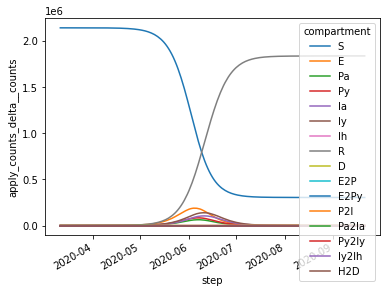

In [3]:
demo_result = main(**cli_pars)

Saving to `zarr` format because of error with `xr.to_netcdf()` (bug in xarray; traceback includes link to open github issue). Note that xarray can only read `zarr` files written by xarray.

In [4]:
demo_result.to_zarr('/Users/kpierce/episimlab/results/DemoATX_78712_start.zarr')

`apply_counts_delta__counts` is the name of the attribute containing the population sizes (counts) for each timestep, compartment, ZCTA, age group, and risk group combination.

In [5]:
data_arr = demo_result['apply_counts_delta__counts']

Use `xr.sel()` to extract the hospitalized ("Ih") compartment, and sum across risk and age groups.

In [6]:
demo_arr_all_risk = data_arr.sel({'compartment': 'Ih'}).sum(dim=['risk_group', 'age_group'])

Plot the hospitalization curve, with timestep ("step") as the x-axis and ZCTA ("vertex") as individual lines on the plot. The legend is suppressed because it's too large to be useful in this rendering (there are 87 ZCTAs).

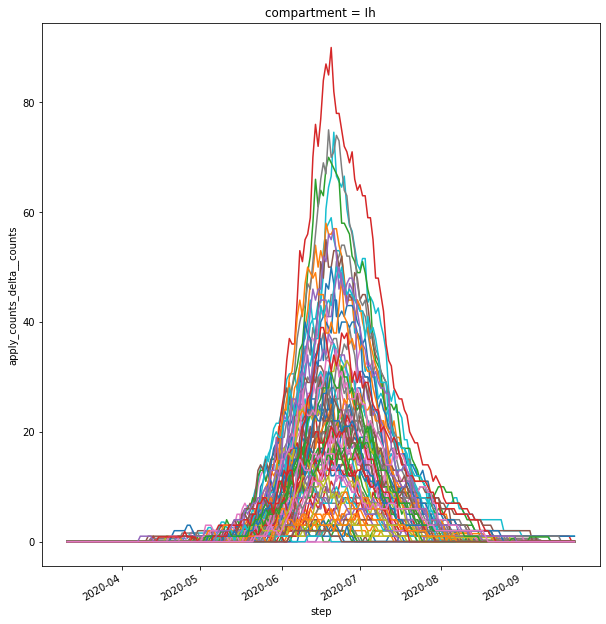

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
demo_arr_all_risk.plot(
    hue='vertex',
    x='step'
)
ax.get_legend().remove()
plt.show()

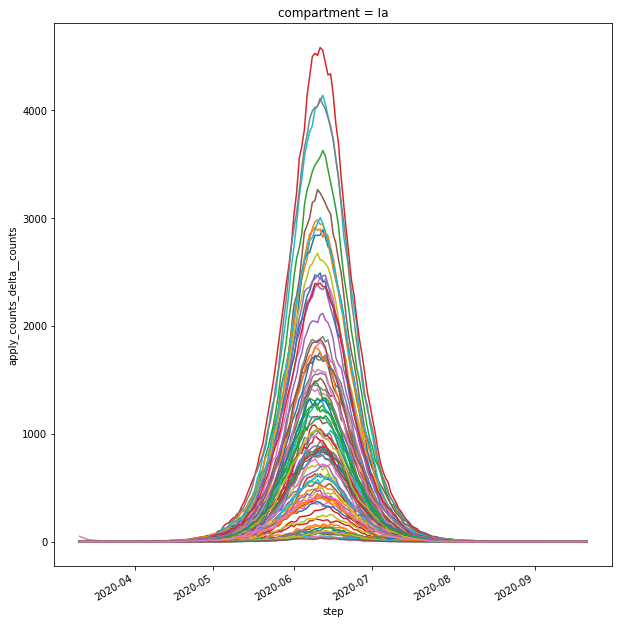

In [9]:
demo_arr_inf = data_arr.sel({'compartment': 'Ia'}).sum(dim=['risk_group', 'age_group'])
fig, ax = plt.subplots(1, 1, figsize=(10,10))
demo_arr_inf.plot(
    hue='vertex',
    x='step'
)
ax.get_legend().remove()
plt.show()

In lieu of a unit test, a sanity check that only 78712 had infections at time 0. (**Note** need to amend `DemoATX.py` to allow specification of an age group and a risk group)

In [16]:
data_arr.sel({'compartment': 'Ia', 'vertex': 78712, 'step': min(data_arr['step'].values)})

<xarray.DataArray 'apply_counts_delta__counts' (age_group: 5, risk_group: 2)>
array([[10.,  0.],
       [10.,  0.],
       [10.,  0.],
       [10.,  0.],
       [10.,  0.]])
Coordinates:
  * age_group    (age_group) <U5 '18-49' '5-17' '50-64' '65+' '<5'
    compartment  <U5 'Ia'
  * risk_group   (risk_group) <U4 'low' 'high'
    step         datetime64[ns] 2020-03-11
    vertex       int64 78712
Attributes:
    _FillValue:  nan

In [15]:
data_arr.sel({'compartment': 'Ia', 'vertex': np.random.choice(data_arr['vertex'].values), 'step': min(data_arr['step'].values)})

<xarray.DataArray 'apply_counts_delta__counts' (age_group: 5, risk_group: 2)>
array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])
Coordinates:
  * age_group    (age_group) <U5 '18-49' '5-17' '50-64' '65+' '<5'
    compartment  <U5 'Ia'
  * risk_group   (risk_group) <U4 'low' 'high'
    step         datetime64[ns] 2020-03-11
    vertex       int64 78626
Attributes:
    _FillValue:  nan

# Decision support vis ideas

... to prototype in a different notebook

- for hospital capacity planning: timing of peak hospitalizations by ZCTA as horizontal boxplots generated by some number of simulations. x axis = time, y axis = ZCTA (categorial axis) 

- for general public health capacity planning (e.g. tests, contact tracing staff, public awareness campaigns): timing of peak infections using the same design as above (**NOTE**: we only provided hospital decision support because we fit to hospitalization data; we should be skeptical of infection peak results that are not fit to infection data)

# Appendix - Data munging

## Rationale for data requirements

The model requires three data files to run:
- "travel dataframe" is derived from safegraph mobility and contains source, destination, date, age, and population (n)
- "contact dataframe" is the the baseline per capita contact probability derived from the Polymod study
- "census dataframe" is the standing population of each ZCTA

The census dataframe is used to initialize the susceptible population sizes at the start of a model run. A small number of infected individuals are pulled out of the specified ZCTA to seed the epidemic (note: this example does not include a "risk group" axis in the census data, so the population is by default "low risk". It looks like a PR to modify `counts.InitCountsFromCensusCSV` will be needed to add ability to parse a risk dimension.

Travel and contact dataframes are used to generate the contact matrix using the `Partition` process in episimlab. Partitioning is done for each time step in the model.

## Load `travel.csv`

In [5]:
tr2020 = pd.read_csv('/Users/kpierce/COVID19/safegraph_mobility/2020_travel_for_contact_partitioning.csv')

In [6]:
tr2020.head()

,Unnamed: 0,source,destination,age,n,date,destination_type
0,0,76511,76511,<5,47.377358,2020-05-30,local
1,1,76511,76511,18-49,638.320755,2020-05-30,local
2,2,76511,76511,5-17,202.754717,2020-05-30,local
3,3,76511,76511,50-64,223.641509,2020-05-30,local
4,4,76511,76511,65+,164.037736,2020-05-30,local


In [114]:
all_zcta = set(tr2020['source'].unique()).union(set(tr2020['destination'].unique()))

In [116]:
names = ["source", "destination", "age", "date"]
multi_ind = pd.MultiIndex.from_product(
    [all_zcta, all_zcta, tr2020['age'].unique(), tr2020['date'].unique()], 
    names=names)
tr2020_full = tr2020.set_index(names).reindex(multi_ind, fill_value=0).reset_index()

In [124]:
start_date = '2020-03-11'
end_date = '2020-09-21'
first_wave = tr2020_full[(tr2020_full['date'] < end_date) & (tr2020_full['date'] >= start_date)]
first_wave.to_csv('/Users/kpierce/episimlab/data/full_first_wave_2020_travel.csv')

## Debugging 3/21/2020

This date causes an assertion error in contact partitioning:

    ~/episimlab/episimlab/partition/partition.py in get_phi(self)
        405         self.phi_t.loc[dict(risk_group1='high', risk_group2='high')] = self.contact_xr
        406         self.phi_t.loc[dict(risk_group1='high', risk_group2='low')] = self.contact_xr
    --> 407         assert not self.phi_t.isnull().any()
        408 
        409     def initialize_misc_coords(self):

    AssertionError: 
    
Problem is fixed above, but retaining these code blocks as notes for identifying problem data.

In [7]:
start_date = '2020-03-11'
end_date = '2020-09-21'
first_wave = tr2020[(tr2020['date'] < end_date) & (tr2020['date'] >= start_date)]

In [8]:
first_wave.to_csv('/Users/kpierce/episimlab/data/first_wave_2020_travel.csv')

In [12]:
debug = tr2020[(tr2020['date'] >= '2020-03-20') & (tr2020['date'] <= '2020-03-23')]
debug.to_csv('/Users/kpierce/episimlab/data/debug_2020_03.csv')

In [24]:
problem_date = debug[debug['date'] == '2020-03-21']
problem_date.to_csv('/Users/kpierce/episimlab/data/debug_20200321_travel.csv')

In [25]:
part = partition.Partition2Contact(
    travel_fp = '/Users/kpierce/episimlab/data/debug_20200321_travel.csv',
    contacts_fp = '/Users/kpierce/episimlab/data/polymod_contacts.csv'
)

In [27]:
part.initialize(
    step_delta=np.timedelta64(24, 'h'),
    step_start=np.datetime64('2020-03-21T00:00:00.000000000'),
    step_end=np.datetime64('2020-03-22T00:00:00.000000000')
)

DEBUG:root:'load_travel_df' took 0.03 seconds
DEBUG:root:step_start: 2020-03-21T00:00:00.000000000
DEBUG:root:step_end: 2020-03-21T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 18:18:10.055960


The date in Partition.get_travel_df is ['2020-03-21T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 18:18:17.640700
DEBUG:root:Starting pandas merge 1 at 2021-07-20 18:18:17.641408
DEBUG:root:Starting pandas merge 2 at 2021-07-20 18:18:23.153807
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 18:18:27.330951
DEBUG:root:'dask_partition' took 19.03 seconds
DEBUG:root:Building contact xarray at 2021-07-20 18:18:29.307892


In [28]:
part.run_step(
    step_delta=np.timedelta64(24, 'h'),
    step_start=np.datetime64('2020-03-21T00:00:00.000000000'),
    step_end=np.datetime64('2020-03-22T00:00:00.000000000')
)

DEBUG:root:step_start: 2020-03-21T00:00:00.000000000
DEBUG:root:step_end: 2020-03-22T00:00:00.000000000
DEBUG:root:Starting dask merge at 2021-07-20 18:18:46.136250


The date in Partition.get_travel_df is ['2020-03-21T00:00:00.000000000']


DEBUG:root:Finishing dask merge at 2021-07-20 18:18:53.147912
DEBUG:root:Starting pandas merge 1 at 2021-07-20 18:18:53.148637
DEBUG:root:Starting pandas merge 2 at 2021-07-20 18:18:57.253766
DEBUG:root:Calculating contact probabilities on full dataframe starting at 2021-07-20 18:19:01.391294
DEBUG:root:'dask_partition' took 17.02 seconds
DEBUG:root:Building contact xarray at 2021-07-20 18:19:03.366629


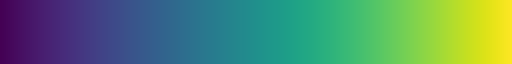

In [85]:
current_cmap

/Users/kpierce/episimlab/esl-venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  This is separate from the ipykernel package so we can avoid doing imports until


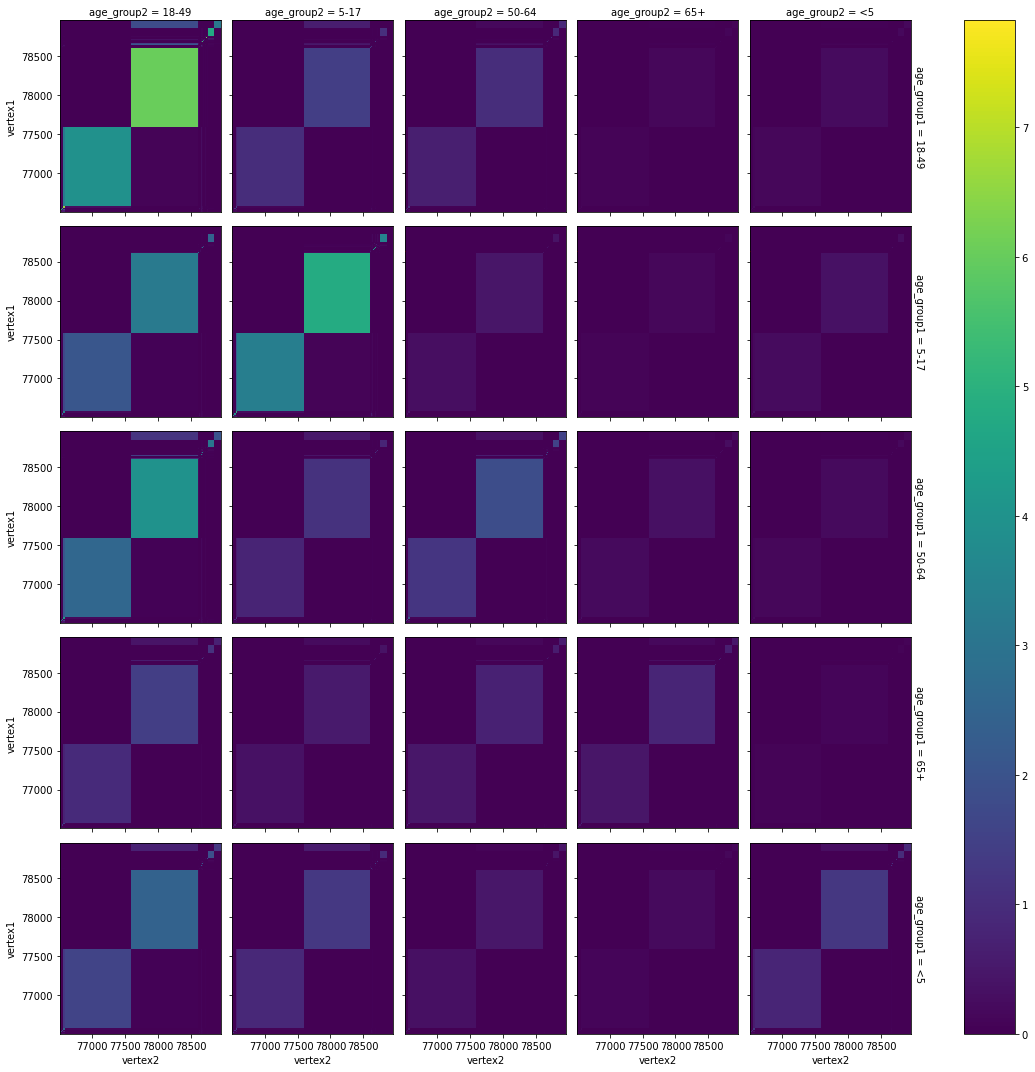

In [86]:
import matplotlib
current_cmap = matplotlib.cm.get_cmap()
current_cmap.set_bad(color='red')
part.contact_xr.plot(row='age_group1', col='age_group2')

In [101]:
np.argwhere(np.isnan(part.contact_xr.values))

array([[ 0, 18,  0,  0],
       [ 0, 18,  0,  1],
       [ 0, 18,  0,  2],
       [ 0, 18,  0,  3],
       [ 0, 18,  0,  4],
       [ 0, 18,  1,  0],
       [ 0, 18,  1,  1],
       [ 0, 18,  1,  2],
       [ 0, 18,  1,  3],
       [ 0, 18,  1,  4],
       [ 0, 18,  2,  0],
       [ 0, 18,  2,  1],
       [ 0, 18,  2,  2],
       [ 0, 18,  2,  3],
       [ 0, 18,  2,  4],
       [ 0, 18,  3,  0],
       [ 0, 18,  3,  1],
       [ 0, 18,  3,  2],
       [ 0, 18,  3,  3],
       [ 0, 18,  3,  4],
       [ 0, 18,  4,  0],
       [ 0, 18,  4,  1],
       [ 0, 18,  4,  2],
       [ 0, 18,  4,  3],
       [ 0, 18,  4,  4],
       [18,  0,  0,  0],
       [18,  0,  0,  1],
       [18,  0,  0,  2],
       [18,  0,  0,  3],
       [18,  0,  0,  4],
       [18,  0,  1,  0],
       [18,  0,  1,  1],
       [18,  0,  1,  2],
       [18,  0,  1,  3],
       [18,  0,  1,  4],
       [18,  0,  2,  0],
       [18,  0,  2,  1],
       [18,  0,  2,  2],
       [18,  0,  2,  3],
       [18,  0,  2,  4],


In [107]:
bad_zip_18 = part.contact_xr['vertex1'][18].values.item()
bad_zip_0 = part.contact_xr['vertex1'][0].values.item()

In [105]:
problem_date.head()

,Unnamed: 0,source,destination,age,n,date,destination_type
3818700,3818700,76511,76511,<5,62.911765,2020-03-21,local
3818701,3818701,76511,76511,18-49,847.617647,2020-03-21,local
3818702,3818702,76511,76511,5-17,269.235294,2020-03-21,local
3818703,3818703,76511,76511,50-64,296.970588,2020-03-21,local
3818704,3818704,76511,76511,65+,217.823529,2020-03-21,local


In [109]:
problem_date[(problem_date['source'] == bad_zip_18) & (problem_date['destination'] == bad_zip_0)]

,Unnamed: 0,source,destination,age,n,date,destination_type


In [110]:
problem_date[(problem_date['source'] == bad_zip_0) & (problem_date['destination'] == bad_zip_18)]

,Unnamed: 0,source,destination,age,n,date,destination_type


Contact partitioning fails because there is no travel between these zip codes on this date.

In [122]:
tr2020_full[
    (tr2020_full['source'] == bad_zip_18) & \
    (tr2020_full['destination'] == bad_zip_0) & \
    (tr2020_full['date'] == '2020-03-21')]

,source,destination,age,date,Unnamed: 0,n,destination_type
2883136,78632,76511,<5,2020-03-21,0,0.0,0
2883467,78632,76511,18-49,2020-03-21,0,0.0,0
2883798,78632,76511,5-17,2020-03-21,0,0.0,0
2884129,78632,76511,50-64,2020-03-21,0,0.0,0
2884460,78632,76511,65+,2020-03-21,0,0.0,0


In [123]:
tr2020_full[
    (tr2020_full['destination'] == bad_zip_18) & \
    (tr2020_full['source'] == bad_zip_0) & \
    (tr2020_full['date'] == '2020-03-21')]

,source,destination,age,date,Unnamed: 0,n,destination_type
321196,76511,78632,<5,2020-03-21,0,0.0,0
321527,76511,78632,18-49,2020-03-21,0,0.0,0
321858,76511,78632,5-17,2020-03-21,0,0.0,0
322189,76511,78632,50-64,2020-03-21,0,0.0,0
322520,76511,78632,65+,2020-03-21,0,0.0,0


# Load `contact.csv`

In [6]:
polymod = pd.read_csv('/Users/kpierce/episimlab/data/polymod_contacts.csv')

In [7]:
polymod

,Unnamed: 0,age1,age2,daily_per_capita_contacts
0,0,<5,<5,2.160941
1,1,5-17,<5,0.597341
2,2,18-49,<5,0.382203
3,3,50-64,<5,0.352397
4,4,65+,<5,0.189756


# Load `census.csv`

In [16]:
census = pd.read_csv('/Users/kpierce/episimlab/data/data_lccf/census_pop1_rows1.csv')

In [17]:
census.head()

,Unnamed: 0,GEOID,NAME,age_bin,group_pop
0,1,75001,ZCTA5 75001,<5,794
1,2,75001,ZCTA5 75001,18-49,9420
2,3,75001,ZCTA5 75001,5-17,1404
3,4,75001,ZCTA5 75001,50-64,2259
4,5,75001,ZCTA5 75001,65+,1115


In [18]:
census[census['GEOID'] == 78712]

,Unnamed: 0,GEOID,NAME,age_bin,group_pop
7590,7591,78712,ZCTA5 78712,<5,0
7591,7592,78712,ZCTA5 78712,18-49,871
7592,7593,78712,ZCTA5 78712,5-17,9
7593,7594,78712,ZCTA5 78712,50-64,0
7594,7595,78712,ZCTA5 78712,65+,0


In [21]:
first_wave = pd.read_csv('/Users/kpierce/episimlab/data/full_first_wave_2020_travel.csv')

(array([1.0822e+04, 2.2700e+02, 3.5000e+01, 2.2000e+01, 2.2000e+01,
        3.1000e+01, 4.3000e+01, 3.2000e+01, 9.0000e+00, 9.0000e+00]),
 array([6.28491620e-03, 6.22607384e+01, 1.24515192e+02, 1.86769645e+02,
        2.49024099e+02, 3.11278552e+02, 3.73533006e+02, 4.35787459e+02,
        4.98041913e+02, 5.60296366e+02, 6.22550820e+02]),
 <BarContainer object of 10 artists>)

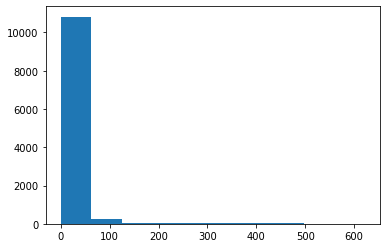

In [23]:
plt.hist(first_wave[(first_wave['source'] == 78712) & (first_wave['n'] > 0)]['n'])